# Projekt zaliczeniowy, analizy danych o kolizjach w mieście Nowy Jork

**Celem projektu jest**:
- Wczytanie danych z pliku csv nypd-motor-vehicle-collisions.csv
- Wyczyszczenie danych
- transformacja danych
- Analiza danych zgodnie z tematami przedstawionymi poniżej i przedstawienie wyników oraz wniosków.

## Tematy projektu

### Wstęp odnośnie podziału administracyjnego miasta Nowy Jork.
Nowy Jork dzieli się na pięć okręgów określanych mianem *boroughs*, do okręgów zaliczamy Manhattan, Bronx, Brooklyn, Queens, Staten Island.\
Dodatkowo okręgi dzielielą sie na mniejsze dzielą się na mniejsze obszry zwane sąsiedztwami *neighborhood*.\
Terminologia okręgów i sąsiedztw bedzie stosowana w dalszej częsci pracy do określania obszarów miasta Nowy Jork.\
Źródło: [Wikipedia](https://pl.wikipedia.org/wiki/Nowy_Jork)

- Sprawdzenie danych, opisanie ich i przygotowanie do dalszych analiz.
- Określenie najniebezpieczniejszych czynników wypadków w każdym z okręgów (boroughs) i sąsiedztw (neighborhood).
- Ilość zgonów oraz rannych spowodowanych przez szybką jazdę w każdym z okręgów i sąsiedztw.
- Określenie czterch najczęstrzych czynników, wypadkóœ z podziałem na okręgi, sąsiedztwa oraz ogółem dla całego miasta.
- Określenie jakie pojazdy najczęściej uczestniczyły w wypadkach.
- Statystyka ilości wypadków dla każdej z dzielnic.
- Wnioski.

### Sprawdzenie danych, opisanie ich i przygotowanie do dalszych analiz.

Ponieważ dane zawarte w pliku nypd-motor-vehicle-collisions.csv są mocno problematyczne ponieważ nie posiadają żadnych opisów co do zawartości kolumn i sposobu ich interpretacji, przyjmuję następujące założenia:
- Pojazdy uczestniczące w kolizji znajdują się w kolumnach 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2','VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5', w konsekwencji w pojedynczej kolizji nie może uczesticzyć więcej niż 5 pojazdów.
- Czynniki kolizji znajdują się w 5 kolumnach CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5' i mogą dotyczyć maksymalnie 5 pojazdów z punktu powyżej i odpowiadją odpowiednio kolumnom 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2','VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5'.
- Zakładam że każdy wiersz jest opisem pojedynczej kolizji w związku z czym pojedyncza kolizja nie znajduje się w wielu wierszach dataset.
- Zkładam że kolumna *'NUMBER OF PERSONS INJURED'* jest sumą kolumn *'NUMBER OF PEDESTRIANS INJURED'*, *'NUMBER OF CYCLIST INJURED'*, *'NUMBER OF MOTORIST INJURED'*
- Zkładam że kolumna *'NUMBER OF PERSONS KILLED'* jest sumą kolumn *'NUMBER OF PEDESTRIANS KILLED'*, *'NUMBER OF CYCLIST KILLED'*, *'NUMBER OF MOTORIST KILLED'*

#### Wczytanie danych z pliku nypd-motor-vehicle-collisions.csv

**Problemy:**
- Dane w kolumny *'ZIP CODE'* składają się z cyfr, białych znaków i wartości NaN, pandas traktuje kolumnę jako składającą się z typu danych mmieszanych.
- Dane w kolumnie *'ACCIDENT DATE'* są w postaci ciągu znaków.

**Rozwiązanie:**
- Wczytanie kolumny *'ZIP CODE'* jako typ danych string (str)
- Wczytanie kolumny *'ACCIDENT DATE'* jako typ danych datetime64

In [1]:
import pandas as pd
import numpy as np
from  tqdm.notebook import tqdm
from shapely import wkt
import geopandas
import geodatasets
import matplotlib.pyplot as plt
import os

In [2]:
nyc_collisions = pd.read_csv("data/nypd-motor-vehicle-collisions.csv",dtype={"ZIP CODE":'str'}, parse_dates=["ACCIDENT DATE"])

#### Podstawowe informacje o wczytanym DataFrame
Wczytany DataFrame nyc_collisions posiada 1 612 178 wierszy w 29 kolumnach.

Informacje o kolumnach DataFrame nyc_collisions, które będą używanew dalszych analizach:
* **ACCIDENT DATE**: Data wypadku, podczas wczytywania kolumna przekształcona na typ danych 'datetime64[ns]'.
* **COLLISION_ID**: Identyfiktor kolizji, typ danych 'int'.
* **LATITUDE**: szerokość geograficzna, typ danych 'float'.
* **LONGITUDE**: długość geograficzna, typ danych 'float'.
* **LOCATION**: lokalizacja geograficzna w postaci punktu, typ danych 'str'..
* **CONTRIBUTING FACTOR VEHICLE**: Kolumny opisujące czynniki, które doprowadziły do kolizji, typ danych 'str'.
* **VEHICLE TYPE CODE**: Kolumny opisujące typy pojazdów uczestniczących w kolizji.
* **NUMBER OF PERSONS INJURED**: Liczba osób rannych w kolizji ogółem.
* **NUMBER OF PERSONS KILLED**: Liczba osób zabitych w kolizjji ogółem.
* **NUMBER OF PEDESTRIANS INJURED**: Liczba pieszych rannych w kolizji.
* **NUMBER OF PEDESTRIANS KILLED**: Liczba pieszych zabitych w kolizji.
* **NUMBER OF CYCLIST INJURED**: Liczba rannych rowerzystów.
* **NUMBER OF CYCLIST KILLED**: Liczba zabitych rowerzystów.
* **NUMBER OF MOTORIST INJURED**: Liczba rannych zmotoryzowanych.
* **NUMBER OF MOTORIST KILLED**: Liczba zabitych zmotoryzowanych.

#### Czyszczenie i sprawdzenie danych w dataframe

##### Kolumna COLLISION_ID

Identyfikator kolizji.
Kolumna zawiera dane typu int64 i będzie używana do jednoznaczego identyfikowania wierszy dataframe nyc_collisions.
Wszystkie wartości w tej kolumnie muszą być unikalne i nie mogą posiadać wartości "pustych" (NaN, None)

**Problemy:**
Identyfikatory kolizji powielają się.

**Rozwiązanie:**
Analiza danych w kolumnie wykazała że niektóre identyfikatory w dataframe powielają się. Powielone identyfikatory powtarzają się maksymalnie 2 razy. Wszystkie wartości w kolumnch dla powielonych wierszy są identyczne. Usuwam duplikaty metodą drop_duplicates, wskazując kolumnę *COLLISION_ID* do identyfikacji duplikatów.

In [3]:
# Ile wierszy w dataframe jest nie unikalnych
non_uniq_values = (nyc_collisions["COLLISION_ID"].value_counts() > 1).sum()
# non_uniq_values

In [4]:
# Wszystkie wiersze z zdupliownymi wartościami COLLISION_ID mają również zduplikowane wartości w innych wszystkich kolumnach.
# Czyli inaczej mówiąc wiersze co do wartości w poszcególnych kolumnach są identyczne.
# Czyszczę DataFrame
count_row_before_drop = len(nyc_collisions)
nyc_collisions = nyc_collisions.drop_duplicates("COLLISION_ID")
count_row_after_drop = len(nyc_collisions)
print(f"Ilość wierszy przed czyszczeniem: {count_row_before_drop}\nIlość wierszy po wyczyszczeniu: {count_row_after_drop}\nIlość wierszy usuniętych: {count_row_before_drop-count_row_after_drop}")
print(f"Wierszy z nieunikalnymi wartościami w kolumnie COLLISION_ID było {non_uniq_values}")

Ilość wierszy przed czyszczeniem: 1612178
Ilość wierszy po wyczyszczeniu: 1217957
Ilość wierszy usuniętych: 394221
Wierszy z nieunikalnymi wartościami w kolumnie COLLISION_ID było 394221


In [5]:
# czyszczenie nie używanych zmiennych
del(non_uniq_values)
del(count_row_before_drop)
del(count_row_after_drop)

##### Kolumny "LATITUDE", "LONGITUDE", "LOCATION"

Kolumny opisujące współrzędne geograficzne kolizji.\
Sprawdzam jak wypełnieone są zależne od siebie kolumny LATITUDE, LONGITUDE i LOCATION.
Zamiana wartości NaN i None na 0.0

Przypadki:
* wszystkie trzy komórki w wierszu dla poszczególnych kolumn posiadają dane
* wszystkie trzy komórki w wierszu dla poszczególnych kolumny są nieuzupełnione
* część komórek w wierszu dla poszczególnych kolumn jest wypełniona a część nie

Wartość False komórki w odpowiadającej kolumnie oznacza że jest uzupełniona, True nie uzupełniona

Sumowanie po osi X wartości boolen (False=0, True=1) w celu określenia statusu uzupełnienia kolumn.

Znczenie sumy wartości logicznych trzech kolumn "LATITUDE","LONGITUDE","LOCATION" w poszczególnych wierszach:

0 - wszystkie kolumny zostały wypełnione\
1 - jedna z trzech komórek wiersza nie została uzupełniona\
2 - dwie z trzech komórek wiersza nie zostały uzupełnione\
3 - wszystkie trzy komórki w wierszu nie zostały uzupełnione

W tym przypadku posiadamy tylko wartości 0 i 3 co oznacza że mamy wiersze w kolumnach "LATITUDE","LONGITUDE","LOCATION" wszystkie uzupełnione albo wszystkie nie uzupełnione. Brak przypadków mieszanych (jedna lub dwie kolumny są uzupełnione a reszta nie), co oszczędzi głębszej analizy, które komórki można uzupełnić na podstawie zawartości inych komórek (np. LATITUDE na podstawie uzupełnionej komórki LOCATION).

Komórka LOCATION zapisana jest jako typ danych str i wygląda jak rekord danych python dictionary:\
`{'type': 'Point', 'coordinates': [-73.790184, 40.676052]}`\
gdzie klucz 'type' określa prawdopodobnie kształt (w tym przypadku punkt) i 'coordinates' współrzędne geograficzne, 
co daje możliwość weryfikacji spójności danych komórek w kolumnach LATITUDE i LONGITUDE na podstawie informacji zawartych w komórkach kolumny LOCATION.

W celu wykonania takiej weryfikacji należy z komórki kolumny LOCATION "wyciągnąć" informacje o współrzędnych geograficznych.
Aby to osiągnąć można potraktować zawartość wierszy kolumny LOCATION jako dane typu json, zamieniając znak ' na znak ", lub bezpośrednio zamienić funkcją eval() ciąg znaków na słownik.

In [6]:
nyc_collisions.loc[:,['LATITUDE', 'LONGITUDE']] = nyc_collisions[['LATITUDE', 'LONGITUDE']].fillna(0.0)

##### Kolumny 'CONTRIBUTING FACTOR VEHICLE 1','CONTRIBUTING FACTOR VEHICLE 2','CONTRIBUTING FACTOR VEHICLE 3','CONTRIBUTING FACTOR VEHICLE 4','CONTRIBUTING FACTOR VEHICLE 5'

Kolumny opisujące czynnik, który doprowadził do kolizji. Typ danych str. Prawdopodobnie odnosi się do stosownej koumny *"VEHICLE TYPE CODE `<NR>`"* pojazdu uczestniczącego w kolizji.\
Sprawdzenie czy wartościach czynników kolizji nie literówek, powielających jeden i ten sam czynnik kolizji.
Wyczyszczenie z danych typ NaN

**Problem:**\
Analiza czynników kolizji może być utrudniona z powodu rozproszenia danych po pięciu kolumnach.

**Rozwiązanie:**\
Utworzenie dodtakowej kolumny *'CONTRIBUTING_FACTORS'*, która połączy wartości (str) w jeden ciąg zanków rozdzielony znakiem ';' z 5 kolumn *CONTRIBUTING FACTOR.*

In [7]:
# Wyczyszczenie danych typu NaN przez zastąpienie ich ciągiem pustym ''
# Transformacja danych: przekształcenie tekstu w poszczególnych komórkach kolumn na duże litery w celu ułatwienia póżniejszych analiz.
cols = ['CONTRIBUTING FACTOR VEHICLE 1','CONTRIBUTING FACTOR VEHICLE 2','CONTRIBUTING FACTOR VEHICLE 3','CONTRIBUTING FACTOR VEHICLE 4','CONTRIBUTING FACTOR VEHICLE 5']
nyc_collisions.loc[:,cols] = nyc_collisions[cols].fillna('')
nyc_collisions.loc[:,cols] = nyc_collisions[cols].apply(lambda v: v.str.strip().str.upper())

In [8]:
# Poprawiam wartości ILLNES na ILLNESS
for c in cols:
    nyc_collisions.loc[nyc_collisions[c] == 'ILLNES',c] = 'ILLNESS'

In [9]:
# Połączenie wartości z 5 kolumn rozdzielonych znakiem ';'
nyc_collisions["CONTRIBUTING_FACTORS"] = nyc_collisions['CONTRIBUTING FACTOR VEHICLE 1'] + ";" + nyc_collisions['CONTRIBUTING FACTOR VEHICLE 2'] + ";" + nyc_collisions['CONTRIBUTING FACTOR VEHICLE 3'] + ";" + nyc_collisions['CONTRIBUTING FACTOR VEHICLE 4'] + ";" + nyc_collisions['CONTRIBUTING FACTOR VEHICLE 5']

##### Kolumny 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2', 'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5'

Kolumny opisujące typ pojazdu, który brał udział w kolizji. Prawdopodobnie odnosi się do stosownej koumny "CONTRIBUTING FACTOR VEHICLE `<NR>`" czynnika który doprowadził do kolizji.
Wyczyszczenie z danych typ NaN. 

**Problem:**
1) Wartości w tych kolumach zawierają bardzo dużo (629) nie ustrukturyzowanych wartości określających typy pojazdów. Część z tych danych trudno określić jako typ pojazdu np. A, 52? T, (CEME, BLUE itd. Duża część danych może określeć ten sam typ pojazdu np. BICYC, BICYCLE, BIKE, BK 
2) Typy pojazdów znajdują się 5 kolumnach.

**Rozwiązanie:**
1) Brak rozwiązania. Nie można określić jakie wartości są prawidłowe jakie nie. Typy pojazdów nie będą zmieniane. Zajęcie bardzo pracochłonne i obarczone błędami. Na wartościach z tych kolumn nie można polegać i można je traktować tylko poglądowo.
2) Utworzenie dodatkowej kolumny *'VEHICLE_TYPES'*, której zawartością będą połączone wartości tekstowe 5 kolumn, rozdzielone znakiem ';'

In [10]:
# Wyczyszczenie danych typu NaN przez zastąpienie ich ciągiem pustym ''
# Transformacja danych, polegające na zamianie wszystkich liter w komórkach kolumn VEHICLE TYPE na duże litery w celu ułatwienia późniejszych analiz.
nyc_collisions.loc[:,['VEHICLE TYPE CODE 1','VEHICLE TYPE CODE 2','VEHICLE TYPE CODE 3','VEHICLE TYPE CODE 4','VEHICLE TYPE CODE 5']] = nyc_collisions[['VEHICLE TYPE CODE 1','VEHICLE TYPE CODE 2','VEHICLE TYPE CODE 3','VEHICLE TYPE CODE 4','VEHICLE TYPE CODE 5']].fillna('')
nyc_collisions.loc[:,['VEHICLE TYPE CODE 1','VEHICLE TYPE CODE 2','VEHICLE TYPE CODE 3','VEHICLE TYPE CODE 4','VEHICLE TYPE CODE 5']] = nyc_collisions[['VEHICLE TYPE CODE 1','VEHICLE TYPE CODE 2','VEHICLE TYPE CODE 3','VEHICLE TYPE CODE 4','VEHICLE TYPE CODE 5']].apply(lambda v: v.str.strip().str.upper())

In [11]:
nyc_collisions['VEHICLE_TYPES'] = nyc_collisions['VEHICLE TYPE CODE 1'] + ";" + nyc_collisions['VEHICLE TYPE CODE 2'] + ";" + nyc_collisions['VEHICLE TYPE CODE 3'] + ";" + nyc_collisions['VEHICLE TYPE CODE 4'] + ";" + nyc_collisions['VEHICLE TYPE CODE 5']

##### Kolumny 'NUMBER OF PERSONS INJURED','NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED','NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED','NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED','NUMBER OF MOTORIST KILLED'.

Opis kolumn:
- "NUMBER OF PERSONS INJURED": Suma liczby osób rannych w kolizji (pieszych, rowerzystów, zmotoryzowanych).
- "NUMBER OF PERSONS KILLED": Suma liczby osób, kóre zgineły w wypadku/kolizji (pieszych, rowerzystów, zmotoryzowanych).
- "NUMBER OF PEDESTRIANS INJURED": liczba rannych pieszych.
- "NUMBER OF PEDESTRIANS KILLED": liczba zabitych pieszych.
- "NUMBER OF CYCLIST INJURED": liczba rannych rowerzystów.
- "NUMBER OF CYCLIST KILLED": liczba zabitych rowerzystów.
- "NUMBER OF MOTORIST INJURED": liczba rannych zmotoryzowanych.
- "NUMBER OF MOTORIST KILLED": liczba zabitych zmotoryzowanych.

**Problemy:**
1) Kolumny posiadają wartości puste (NaN, None)
2) Niektóre kolumny posiadają typ wartości zminno przecinkowy, a inne całkowity
3) W niektórych przypadkach kolumna *'NUMBER OF PERSONS INJURED'* posiada wartość, która nie jest sumą wartości kolumn *'NUMBER OF PEDESTRIANS INJURED'*, *'NUMBER OF CYCLIST INJURED'*, *'NUMBER OF MOTORIST INJURED'*
4) W niektórych przypadkach kolumna *'NUMBER OF PERSONS KILLED'* posiada wartość, która nie jest sumą wartości kolumn *'NUMBER OF PEDESTRIANS KILLED'*, *'NUMBER OF CYCLIST KILLED'*, *'NUMBER OF MOTORIST KILLED'*

**Rozwiązanie:**
1) Wyczyszczenie kolumn z wartości pustych (NaN, None) poprzez zmianę tych wartości na 0
2) Zamiana wszystkich wartości zmienno przecinkowych całkowite.
3)  Uzupełnienie kolumny *"NUMBER OF PERSONS INJURED"* na podstawie wartości w kolumnach *'NUMBER OF PEDESTRIANS INJURED'*, *'NUMBER OF CYCLIST INJURED'*, *'NUMBER OF MOTORIST INJURED'*. Ponieważ niezgodności sumy osób rannych z kolumn *"NUMBER OF PEDESTRIANS INJURED"*, *"NUMBER OF CYCLIST INJURED"*, *"NUMBER OF MOTORIST INJURED"* w kolumnie *"NUMBER OF PERSONS INJURED"* jes dwukierunkowa co do wartości (tzn. suma jest większa i mniejsza), zakładam gorszą sytuację i kolumnę *"NUMBER OF PEDESTRIANS INJURED"*, przeliczam do wartości największej.
4)  Jak w punkcie 3) tylko dotyczy to kolumn *'NUMBER OF KILLED'*

In [12]:
# Transformacja danych, pozbycie się ewewntualnych wartości NaN, poprzez zamianę NaN na wartośc 0
nyc_collisions.loc[:,['NUMBER OF PERSONS INJURED','NUMBER OF PERSONS KILLED','NUMBER OF PEDESTRIANS INJURED','NUMBER OF PEDESTRIANS KILLED','NUMBER OF CYCLIST INJURED','NUMBER OF CYCLIST KILLED','NUMBER OF MOTORIST INJURED','NUMBER OF MOTORIST KILLED']] = nyc_collisions[['NUMBER OF PERSONS INJURED','NUMBER OF PERSONS KILLED','NUMBER OF PEDESTRIANS INJURED','NUMBER OF PEDESTRIANS KILLED','NUMBER OF CYCLIST INJURED','NUMBER OF CYCLIST KILLED','NUMBER OF MOTORIST INJURED','NUMBER OF MOTORIST KILLED']].fillna(0)

In [13]:
# Zmiana typu float64 kolumn 'NUMBER OF PERSONS INJURED' i 'NUMBER OF PERSONS KILLED' na typ int64.
nyc_collisions = nyc_collisions.astype({"NUMBER OF PERSONS INJURED": 'int64', "NUMBER OF PERSONS KILLED": 'int64'})
# print("NUMBER OF PERSONS INJURED: ", nyc_collisions["NUMBER OF PERSONS INJURED"].dtype)
# print("NUMBER OF PERSONS KILLED: ", nyc_collisions["NUMBER OF PERSONS KILLED"].dtype)

In [14]:
# Sprawdzenie czy wartości w kolumnie 'NUMBER OF PERSONS INJURED' są sumą wartości z kolumn 'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF CYCLIST INJURED', 'NUMBER OF MOTORIST INJURED'.
maps = nyc_collisions[['NUMBER OF PEDESTRIANS INJURED','NUMBER OF CYCLIST INJURED','NUMBER OF MOTORIST INJURED']].sum(axis=1) != nyc_collisions["NUMBER OF PERSONS INJURED"]
# (maps).sum()

In [15]:
# Uzupełnienie kolumny "NUMBER OF PERSONS INJURED" na podstawie wartości w kolumnach 'NUMBER OF PEDESTRIANS INJURED','NUMBER OF CYCLIST INJURED','NUMBER OF MOTORIST INJURED'
# Ponieważ niezgodności sumy osób rannych z kolumn "NUMBER OF PEDESTRIANS INJURED", "NUMBER OF CYCLIST INJURED", "NUMBER OF MOTORIST INJURED"
# w kolumnie "NUMBER OF PERSONS INJURED" jes dwukierunkowa co do wartości (tzn. suma jest większa i mniejsza), zakładam gorszą sytuację i 
# kolumnę "NUMBER OF PEDESTRIANS INJURED", przeliczam do wartości największej.
nyc_collisions.loc[:,"INJURED"] = nyc_collisions[['NUMBER OF PEDESTRIANS INJURED','NUMBER OF CYCLIST INJURED','NUMBER OF MOTORIST INJURED']].sum(axis=1)
nyc_collisions.loc[:,'NUMBER OF PERSONS INJURED'] = nyc_collisions[['NUMBER OF PERSONS INJURED','INJURED']].max(axis=1)
nyc_collisions = nyc_collisions.drop("INJURED",axis=1)

In [16]:
# Sprawdzenie czy wartości w kolumnie 'NUMBER OF PERSONS KILLED' są sumą wartości z kolumn 'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST KILLED'.
maps = nyc_collisions[['NUMBER OF PEDESTRIANS KILLED','NUMBER OF CYCLIST KILLED','NUMBER OF MOTORIST KILLED']].sum(axis=1) != nyc_collisions["NUMBER OF PERSONS KILLED"]
# (maps).sum()

In [17]:
# Uzupełnienie kolumny "NUMBER OF PERSONS KILLED" na podstawie wartości w kolumnach 'NUMBER OF PEDESTRIANS KILLED','NUMBER OF CYCLIST KILLED','NUMBER OF MOTORIST KILLED'
# Ponieważ niezgodności sumy osób zabitych z kolumn "NUMBER OF PEDESTRIANS KILLED", "NUMBER OF CYCLIST KILLED", "NUMBER OF MOTORIST KILLED"
# w kolumnie "NUMBER OF PERSONS KILLED" jes dwukierunkowa co do wartości (tzn. suma jest większa i mniejsza), zakładam gorszą sytuację i 
# kolumnę "NUMBER OF PEDESTRIANS KILLED", przeliczam do wartości największej.
nyc_collisions.loc[:,"KILLED"] = nyc_collisions[['NUMBER OF PEDESTRIANS KILLED','NUMBER OF CYCLIST KILLED','NUMBER OF MOTORIST KILLED']].sum(axis=1)
nyc_collisions.loc[:,'NUMBER OF PERSONS KILLED'] = nyc_collisions[['NUMBER OF PERSONS KILLED','KILLED']].max(axis=1)
nyc_collisions = nyc_collisions.drop("KILLED",axis=1)

##### Kolumna BOROUGH

Kolumna wskazuje okręg miasta Nowy Jork w którym doszło do kolizji/wypadku.

**Problemy:**
1) Kolumna posiada wartości puste (NaN, NULL) oraz puste ciągi znaków ''.
2) Problem z wartościami tekstowymi typu wielkość znaków i białe znaki na początku i końcu tekstu.
3) Nie uzupełnione nazwy okręgów, (130419 rekordów nie uzupełnionych na 1217957, czyli 10,71% wszystkich danych).

**Rozwiązanie:**
1) Przekształcenie wszystkich wartości pustych typu Nan, None na pusty ciąg znaków ''.
2) Przekształcenie nazw okręgów na pisane tylko duzymi literami i usunięcie wiądących i końcowych białych znaków.
3) Uzupełnienie nazw okręgów na podstawie lokalizacji geograficznej.

In [18]:
# Wyczyszczenie danych typu NaN przez zastąpienie ich ciągiem pustym ''
# Transformacja danych przez zmianę tekstu na duże litery w celu ułatwienia późniejszych analiz i porównywanie tekstu
nyc_collisions.loc[:,['BOROUGH']] = nyc_collisions["BOROUGH"].fillna('')
nyc_collisions.loc[:,'BOROUGH'] = nyc_collisions.loc[:,'BOROUGH'].str.strip().str.upper()
# nyc_collisions.loc[:,['BOROUGH']] = nyc_collisions['BOROUGH'].apply(lambda v: v.strip().upper())

##### Kolumny 'ON STREET NAME','CROSS STREET NAME','OFF STREET NAME'

Kolumny nie będą używane w dalszych analizach.

#### Przygotowanie danych GIS

Wczytanie poligonu geogograficznego miasta Nowy Jork z dokładnością do sąsiedztw.
Korzystam z wiedzy z serwisu https://www.kaggle.com/code/geowiz34/maps-of-nyc-airbnbs-with-python.
Dane geograficzne miasta Nowy Jork zostały pobrane z strony https://data.cityofnewyork.us/City-Government/Neighborhood-Tabulation-Areas/cpf4-rkhq i wyeksportowane do pliku nynta.csv

Plik nynta.zip został dołączony do repozytorum na github. Po sklonowaniu repozytorium plik należy rozpakować. Plik znajduje się w folderze jupyter/data.

*Zostaną utworzone dodatkowe zbiory danych zawierające:*
- neighborhood: informacje GIS o sąsiedztwach maista Nowy Jork i ich przynależności do okręgów.
- boroughs: informacje GIS o okręgach miasta Nowy Jork.
- gis_nyc_collisions: Informacje GIS o kolizjach w mieście Nowy Jork. Gotowy plik

##### Utworzenie GeoDataFrame neighborhood z poligonami sąsiedztw miasta Nowy Jork

Przekonwertowanie neighborhood z typu pandas DataFrame na geopandas GeoDataFrame.
Przekonwertowanie danych geograficznych zawartych w DataFrame neighborhood (typu pandas) w kolumnie *the_geom na typ danych odpowiedni dla geopandas, przez utworzenie kolumny *geom* z współrzędnymi geograficznymi obszarów miasta Nowy Jork w formacie [Well-known text](https://en.wikipedia.org/wiki/Well-known_text_representation_of_geometry). Typ danych kolumny geom będzię używany w dalszych analizach. Sposób konwertowania kolumny the_geom na well-know text został opisany w serwisie https://www.kaggle.com/code/geowiz34/maps-of-nyc-airbnbs-with-python.

In [19]:
# Pobieram współrzędne geograficzne granic pligonów miasta Nowy Jork z dokładnością do sąsiedztw
# W folderze data znajduje się plik nynta.zip, który należy rozpakować.
neighborhood = pd.read_csv('data/nynta.csv')
# neighborhood.head(3)

In [20]:
neighborhood.rename(columns={'NTAName':'neighbourhood'}, inplace=True)
neighborhood['geom'] = neighborhood['the_geom'].apply(wkt.loads)
neighborhood = geopandas.GeoDataFrame(neighborhood, geometry='geom')
neighborhood["BoroName"] = neighborhood["BoroName"].str.strip().str.upper()
# neighborhood.head(3)

##### Utworzenie GeoDataFrame boroughs z poligonami okręgów miasta Nowy Jork

Źródło: https://stackoverflow.com/questions/38899190/geopandas-label-polygons

In [21]:
# Okręgi NYC
# https://stackoverflow.com/questions/38899190/geopandas-label-polygons
boroughs = geopandas.read_file(geodatasets.get_path("nybb"))
boroughs["coords"] = boroughs['geometry'].apply(lambda x: x.representative_point().coords[:])
boroughs["coords"] = [coords[0] for coords in boroughs["coords"]]
boroughs["BoroName"] = boroughs["BoroName"].str.strip().str.upper()
boro_dict = boroughs[["BoroName","BoroCode"]].set_index("BoroName",drop=True).to_dict()["BoroCode"]
# boro_dict_code = boroughs[["BoroName","BoroCode"]].set_index("BoroCode",drop=True).to_dict()["BoroName"]

##### Utworzenie GeoDataFrame gis_nyc_collisions z informacjami o lokalizacji geograficznej kolizji

**Problem:**\
GeoDataFrame został utworzony na podstawie dataframe nyc_collisions, który zawiera lokalizacje, które nie należą do obszaru miast Mowy Jork.

**Rozwiązanie:**\
Obszar miast Nowy Jork, znajduje się miej więcej pomiędzy długością geograficzną -73.67W a 74.3W, szerokością geograficzną 40.48N a 40.92N
W GeoDataFrame gis_nyc_collisions teorzę kolumnę "LocationNYC" z wartościami typu Boolen, która wszystkie współrzędne geograficzne z przedziału w/w obszaru oznacza jako True (znajdują się w Nowym Jorku lub w pobliżu) i False oznaczające współrzędne, które są błędne lub znajdują się poza obszarem wyznaczonym przez w/w obszar.
Kolumnę "LocationNYC", tworzę tylko na potrzeby wygodnego określenia, które punkty będą odrysowane na mapie

In [22]:
# TEST
nyc_collisions.loc[nyc_collisions["COLLISION_ID"].isin([3580632,4186095])][["COLLISION_ID","BOROUGH","LOCATION","LONGITUDE","LATITUDE"]]

COLLISION_ID        BOROUGH  \
2439         4186095  STATEN ISLAND   
886621       3580632  STATEN ISLAND   

                                                 LOCATION  LONGITUDE  LATITUDE  
2439                                                  NaN    0.00000    0.0000  
886621  {'type': 'Point', 'coordinates': [-73.91576, 4...  -73.91576   40.8467

In [23]:
# Utworzenie DataFrame zawierajającego współrzędne geograficzne kolizji i identyfikatora kolizji
# geo_collisions będzię używany do nanoszenia punktów kolizji na mapę miasta Nowy Jork
gis_nyc_collisions = nyc_collisions[["LONGITUDE","LATITUDE","COLLISION_ID","BOROUGH"]].loc[~nyc_collisions["LOCATION"].isna()].copy().reset_index(drop=True)
# gis_nyc_collisions.head(3)

In [24]:
# Utworzenie kolumny point_collision zawierającego współrzędne geograficzne kolizji i przekonwertowanie z typu pandas DataFrame do geopandas GeoDataFrame
gis_nyc_collisions["point_collision"] = geopandas.GeoDataFrame(geopandas.points_from_xy(gis_nyc_collisions.LONGITUDE,gis_nyc_collisions.LATITUDE),columns=["point_collision"])
# Kolumna point_collision zawiera obiekty (punkty), które będą odrysowane na mapie miasta Nowy Jork
gis_nyc_collisions = geopandas.GeoDataFrame(gis_nyc_collisions, geometry='point_collision')
# gis_nyc_collisions.head(3)

In [25]:
# Określnie lokalizacj gegoraficznych leżących w obszarze miasta Nowy Jork
gis_nyc_collisions["LocationNYC"] = False
gis_nyc_collisions["LocationNYC"] =  ((gis_nyc_collisions.LONGITUDE < -73.67) & (gis_nyc_collisions.LONGITUDE > -74.3) & (gis_nyc_collisions.LATITUDE > 40.48) & (gis_nyc_collisions.LATITUDE < 40.92))

In [26]:
# 240619
def get_ntacode(point):
    data = neighborhood["NTACode"].loc[neighborhood["geom"].contains(point)].values
    if len(data):
        return data[0]
    return None

if os.path.isfile("data/geo.json"):
    # Wczytanie danych z pliku. Trwa parę minut ...
    print("z pliku ...")
    gis_nyc_collisions = geopandas.read_file("data/geo.json")
else:
    print("Tworzę ...")
    gis_nyc_collisions["NTACode"] = gis_nyc_collisions['point_collision'].apply(lambda p: get_ntacode(p))
    gis_nyc_collisions.to_file("data/geo.json",driver="GeoJSON",index=False)
gis_nyc_collisions = gis_nyc_collisions.astype({"COLLISION_ID": 'int'})

z pliku ...


In [27]:
gis_nyc_collisions = gis_nyc_collisions.merge(neighborhood[["NTACode","BoroName","BoroCode"]],on="NTACode",how="left")
gis_nyc_collisions.loc[:,"BoroCode"] = gis_nyc_collisions.loc[:,"BoroCode"].fillna(0)
gis_nyc_collisions = gis_nyc_collisions.astype({"BoroCode": 'int'})

In [28]:
# Przypisanie brakujących okregów na podstawie lokalizacji
maps = (gis_nyc_collisions["BOROUGH"] == "") & (~gis_nyc_collisions["BoroName"].isna())
gis_nyc_collisions.loc[maps,"BOROUGH"] = gis_nyc_collisions.loc[maps,"BoroName"]
gis_nyc_collisions = gis_nyc_collisions.drop(columns=["BoroName"])
# gis_nyc_collisions

In [29]:
# Lokalizacje które posiadają nazwę dzielnicy a nie posiadają BoroCode
maps = gis_nyc_collisions["BOROUGH"].loc[(gis_nyc_collisions["BoroCode"] == 0) & (gis_nyc_collisions["BOROUGH"] != "")].map(boro_dict)
gis_nyc_collisions.loc[maps.index,"BoroCode"]=maps

In [30]:
# Zmiana nazwy kolumny żeby nie kolidowała z nyc_collisions["BOROUGH"]
gis_nyc_collisions = gis_nyc_collisions.rename(columns={"BOROUGH":'BoroName'})

##### Uzupełnienie nazw okręgów w dataframe nyc_collisions na podstawie lokalizacji geograficznej.

In [31]:
# Uzupełnienie kolumny BOROUGH w DataFrame ny_collisions na podstawie kolumny BoroName z geo_collisions czyli po lolkalizacji geograficznej
nyc_collisions = nyc_collisions.merge(gis_nyc_collisions[["COLLISION_ID","BoroName","BoroCode"]], on="COLLISION_ID", how="left")

In [32]:
# Uzupełnienie kolumny BOROUGH w dataframe nyc_collisions na podstawie lokalizacji geofraficznej
nyc_collisions.loc[(nyc_collisions["BOROUGH"] == '') & (nyc_collisions["BoroName"].str.len() > 0),"BOROUGH"] = nyc_collisions.loc[(nyc_collisions["BOROUGH"] == '') & (nyc_collisions["BoroName"].str.len() > 0),"BoroName"]

In [33]:
# Usunięcie zbędnej kolumny
nyc_collisions = nyc_collisions.drop(columns=["BoroName"])

In [34]:
# Wyczyszczeni watości NaN z BoroCode
# a = len(nyc_collisions)
# nyc_collisions.loc[nyc_collisions["BoroCode"].isna()][["BOROUGH","BoroCode"]]
nyc_collisions.loc[:,"BoroCode"] = nyc_collisions["BoroCode"].fillna(0.0)
nyc_collisions = nyc_collisions.astype({"BoroCode": 'int'})
# display(a,len(nyc_collisions))

### Analiza danych

Analiza danych o kolizjach w mieście Nowy Jork została podzielona na dwie częsci:
- Analiza danych w oparciu o wszystkie dostępne dane, bez uwzględnienia lokalizacji geograficznej.
- Analiza danych oparta na lokalizacji geogeaficznej, uwzględnia dane które udało się przyporządkować po lokalizacji geograficznej do miasta Nowy Jork.

#### Analiza danych w oparciu o wszystkie dostępne dane, bez uwzględnienia lokalizacji geograficznej.

Zakres dat objęty analizą wynosi:

In [35]:
# okres czasu
nyc_collisions["ACCIDENT DATE"].agg(['min','max'])

min   2012-07-01
max   2019-11-26
Name: ACCIDENT DATE, dtype: datetime64[ns]

#### ilość kolizji w podziale na okręgi NYC oraz całkowia (TOTAL) za cały dostępny okres czasu.

In [36]:
# ilość kolizji w podziale na okręgi NYC oraz całkowia (TOTAL)
collision_by_borough = nyc_collisions.groupby("BOROUGH")["COLLISION_ID"].count()
collision_by_borough.name = "COUNT"
collision_by_borough = collision_by_borough.rename({'':'UNKNOW'})
collision_by_borough["TOTAL"] = collision_by_borough.sum()
proc = 100*collision_by_borough["UNKNOW"]/collision_by_borough["TOTAL"]
collision_by_borough.sort_values()

BOROUGH
STATEN ISLAND      53648
UNKNOW            130419
BRONX             155334
MANHATTAN         246998
QUEENS            310050
BROOKLYN          321508
TOTAL            1217957
Name: COUNT, dtype: int64

**Ilość kolizji w podziale na okręgi NYC**

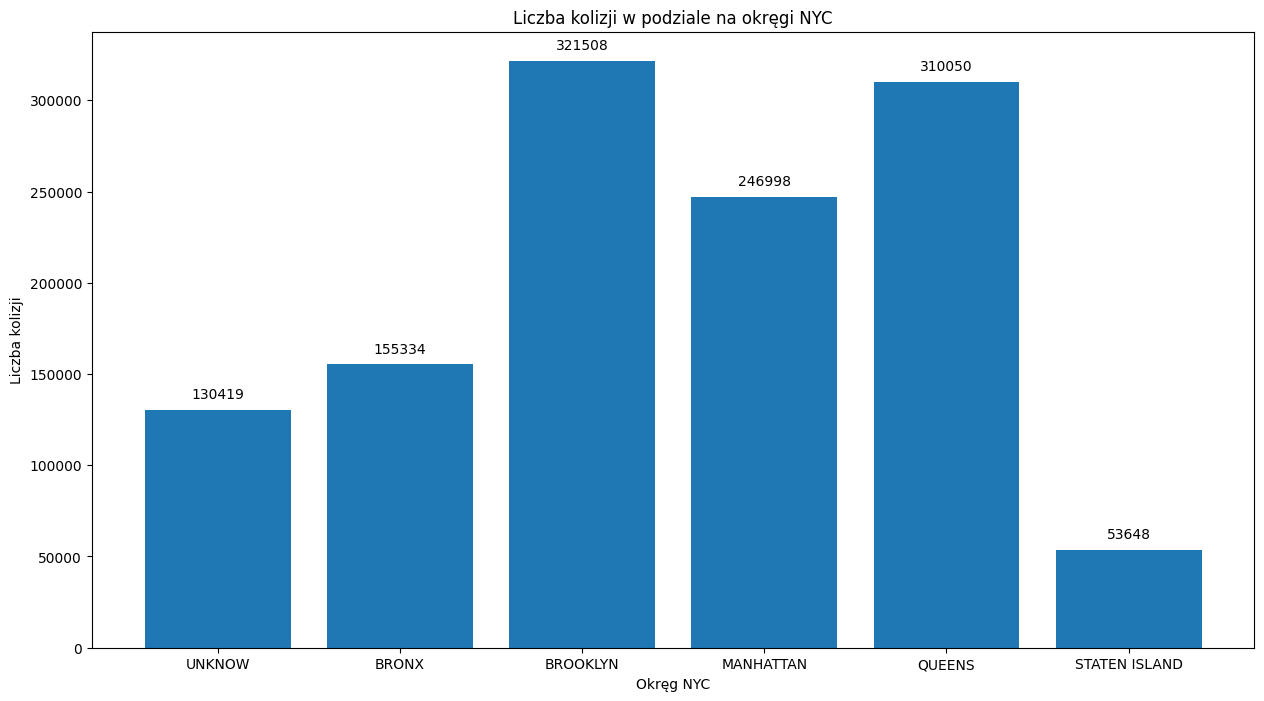

In [37]:
# Ilość kolizji w podziale na okręgi NYC
fig, ax = plt.subplots(figsize=(15,8))
p = ax.bar(collision_by_borough.index.to_list()[:-1],collision_by_borough[:-1])
ax.bar_label(p, padding=6);
ax.set_ylabel("Liczba kolizji")
ax.set_xlabel("Okręg NYC")
ax.set_title("Liczba kolizji w podziale na okręgi NYC");
# ax.ticklabel_format(style='plain',axis='y')
# ax.set_ylim(0, 1_100_000);

In [38]:
print(f"Dane o kolizjach które nie udało sie przyporządkować do żadnego okręgu znajdują się w grupie UNKOWN. Stanowią one {proc:.2f}% wszystkich danych.")

Dane o kolizjach które nie udało sie przyporządkować do żadnego okręgu znajdują się w grupie UNKOWN. Stanowią one 10.71% wszystkich danych.


#### ilość kolizji w pełnych latach w podziale na okręgi miasta Nowy Jork.

Pod uwagę biorę tylko pełne lata zawarte w danych o kolizjach. Nie uwzględniono roku 2012 i 2019 z powodu braku pełnych danych w tych latach.

In [39]:
collisions_boro_by_year = nyc_collisions.loc[(nyc_collisions["ACCIDENT DATE"].dt.year > 2012) & (nyc_collisions["ACCIDENT DATE"].dt.year < 2019)].groupby([nyc_collisions["ACCIDENT DATE"].dt.year,"BOROUGH"])["COLLISION_ID"].count().to_frame().unstack()
collisions_boro_by_year = collisions_boro_by_year.rename(columns={'':'UNKNOWN'})
collisions_boro_by_year = collisions_boro_by_year.rename(columns={'COLLISION_ID':'NUMBER OF COLLISIONS PER YEAR'},level=0)
collisions_boro_by_year[('NUMBER OF COLLISIONS PER YEAR',"TOTAL")] = collisions_boro_by_year.sum(axis=1)
collisions_boro_by_year

NUMBER OF COLLISIONS PER YEAR                                   \
BOROUGH                             UNKNOWN  BRONX BROOKLYN MANHATTAN QUEENS   
ACCIDENT DATE                                                                  
2013                                  21904  14754    34523     30098  32157   
2014                                  25540  16266    39501     33829  37800   
2015                                  24166  16274    38865     32012  37061   
2016                                  17477  23046    46903     35625  44719   
2017                                   9500  25179    47156     34208  45320   
2018                                  10338  27926    51278     35501  50637   

                                     
BOROUGH       STATEN ISLAND   TOTAL  
ACCIDENT DATE                        
2013                   6786  140222  
2014                   5889  158825  
2015                   5396  153774  
2016                   8033  175803  
2017                   8638  170001  
2018                   9423  185103

**Liczba kolizji w okręgach NYC w podziale na pełne lata**\
Kolumna UNKNOWN wskazuje na kolizje, które nie zostały przyporządkowane do żadnych okręgów (problematyczny zbiór danych).

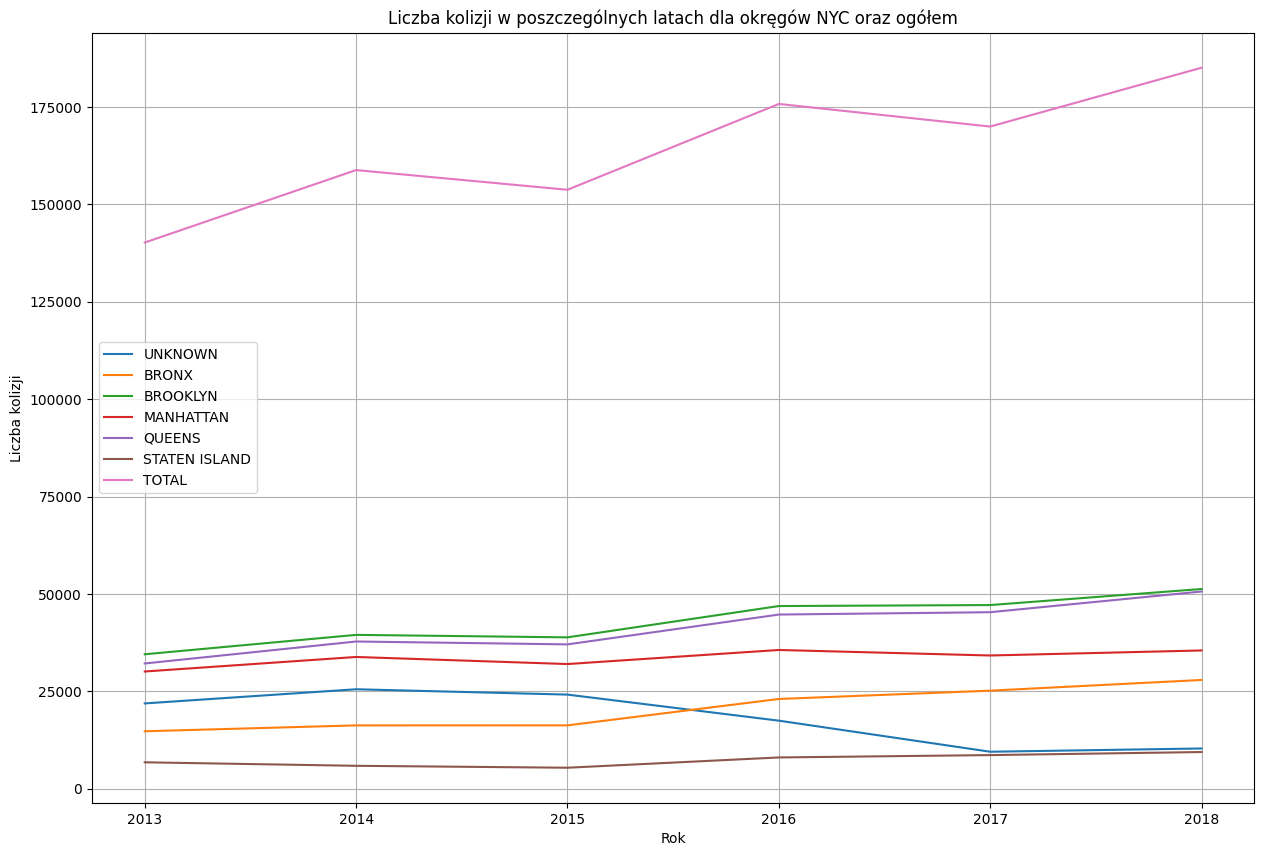

In [40]:
# Wykres ilości kolizji w podziale na okręgi w poszczególnych latach
fig,ax = plt.subplots(figsize=(15,10))
for col in collisions_boro_by_year:
    ax.plot(collisions_boro_by_year.index,collisions_boro_by_year[col],label=col[1])
ax.legend(loc='center left')
ax.set_title("Liczba kolizji w poszczególnych latach dla okręgów NYC oraz ogółem")
ax.set_ylabel("Liczba kolizji")
ax.set_xlabel("Rok")
plt.grid()
plt.show()

**Wnioski:**\
Posiadamy pewną część problematycznych danych, których nie można przyporządkować do żadnego z okręgów miasta Nowy Jork (grupa UNKNOW). Na wykresie widać, że ilość kolizji z grupy UNKNOW, znacznie przekracza liczbę kolizji okręgu STATEN ISLAND, więc analiza jest obarczona błędem, ktorego nie da się wyeliminować z względu na problematyczne dane.
Z danych które są dostępne wynika że okręg *STATEN ISLAND* posiada najmniejszą liczbę kolizji. *STATEN ISLAND* posiada najmniejszą populację mieszkańców.\
Największą liczbę kolizji wykazał się okręg *BROOKLYN*, jeden z najludnieszych okręgów miasta.\
Wykres liczby kolizji w podziale na lata, wykazuje tendencje do wzrostu liczby kolizji.

#### Określenie najniebezpieczniejszych czynników wypadków w każdej z dzielnic NYC

In [41]:
# Funkcja zliczająca wartości z kolumn col, dataframe df pogrupowanym po kolumnie gr.
# Zwraca ilość czynników w poszczególnych grupach w postaci dataframe, gdzie wiersze to czynniki a kolumny to grupy.
# Funkcja zostanie użyta do określenia czynników wypadków w każdej z dzielnic NYC i typów pojazdów uczestniczących w kolizji
def count_value_by_group(df,gr,col):
    ret = None
    for val in df.groupby(gr)[col]:
        factors =  pd.Series(0,index=df[col].stack().unique())
        for c in val[1]:
            f = val[1][c].value_counts()
            factors = factors.add(f,fill_value=0)
        factors.name = val[0] if len(val[0]) > 0 else 'UNKNOWN'
        if ret is None:
            ret = pd.DataFrame(factors)
        else:
            ret = pd.concat([ret,factors],axis=1)
    ret["TOTAL"] = ret.sum(axis=1)
    ret = ret.drop('',axis='index')
    return ret

In [42]:
# Określenie czynników kolizji z kolumn 'CONTRIBUTING FACTOR VEHICLE' dla każdej dzielnicy NYC (kolumna BOROUGH)
contributing_factor = count_value_by_group(nyc_collisions,"BOROUGH",['CONTRIBUTING FACTOR VEHICLE 1','CONTRIBUTING FACTOR VEHICLE 2','CONTRIBUTING FACTOR VEHICLE 3','CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5'])
contributing_factor.sort_values(ascending=False,by="TOTAL")
# najczęstrze czynniki kolizji dla wszystkich dzielnic NYC

UNKNOWN     BRONX  \
UNSPECIFIED                                         159720.0  183006.0   
DRIVER INATTENTION/DISTRACTION                       26607.0   31479.0   
FAILURE TO YIELD RIGHT-OF-WAY                         6197.0    7892.0   
FOLLOWING TOO CLOSELY                                 9824.0    9758.0   
OTHER VEHICULAR                                       5868.0   10535.0   
BACKING UNSAFELY                                      4008.0    6876.0   
FATIGUED/DROWSY                                       9186.0    2962.0   
TURNING IMPROPERLY                                    4688.0    4432.0   
PASSING OR LANE USAGE IMPROPER                        2799.0    4496.0   
PASSING TOO CLOSELY                                   1274.0    4780.0   
UNSAFE LANE CHANGING                                  3232.0    4520.0   
TRAFFIC CONTROL DISREGARDED                           2369.0    2911.0   
DRIVER INEXPERIENCE                                   2148.0    2658.0   
LOST CONSCIOUSNESS                                    2831.0    1172.0   
PAVEMENT SLIPPERY                                     1882.0    2026.0   
PRESCRIPTION MEDICATION                               2031.0    1311.0   
REACTION TO UNINVOLVED VEHICLE                        1378.0    1961.0   
UNSAFE SPEED                                          1069.0    2308.0   
ALCOHOL INVOLVEMENT                                   1317.0    1818.0   
OUTSIDE CAR DISTRACTION                               1934.0    1137.0   
OVERSIZED VEHICLE                                      896.0    1008.0   
VIEW OBSTRUCTED/LIMITED                                716.0    1567.0   
PHYSICAL DISABILITY                                   1242.0     715.0   
PASSENGER DISTRACTION                                  461.0     789.0   
AGGRESSIVE DRIVING/ROAD RAGE                           579.0     981.0   
PEDESTRIAN/BICYCLIST/OTHER PEDESTRIAN ERROR/CON...     238.0     901.0   
BRAKES DEFECTIVE                                       543.0     640.0   
FELL ASLEEP                                            347.0     402.0   
OBSTRUCTION/DEBRIS                                     392.0     372.0   
GLARE                                                  355.0     500.0   
ILLNESS                                                242.0     250.0   
FAILURE TO KEEP RIGHT                                  316.0     283.0   
OTHER ELECTRONIC DEVICE                                324.0     235.0   
PAVEMENT DEFECTIVE                                     200.0     218.0   
TIRE FAILURE/INADEQUATE                                203.0     194.0   
STEERING FAILURE                                       148.0     208.0   
REACTION TO OTHER UNINVOLVED VEHICLE                   191.0     118.0   
LANE MARKING IMPROPER/INADEQUATE                       159.0     132.0   
ANIMALS ACTION                                         100.0     107.0   
DRUGS (ILLEGAL)                                         92.0     120.0   
TRAFFIC CONTROL DEVICE IMPROPER/NON-WORKING            116.0      80.0   
DRIVERLESS/RUNAWAY VEHICLE                              20.0     127.0   
ACCELERATOR DEFECTIVE                                   73.0      78.0   
CELL PHONE (HAND-HELD)                                  30.0      71.0   
CELL PHONE (HANDS-FREE)                                 30.0      15.0   
OTHER LIGHTING DEFECTS                                  17.0      15.0   
TOW HITCH DEFECTIVE                                     14.0      13.0   
80                                                      12.0      20.0   
HEADLIGHTS DEFECTIVE                                    12.0       8.0   
TINTED WINDOWS                                           5.0      22.0   
USING ON BOARD NAVIGATION DEVICE                        16.0      18.0   
VEHICLE VANDALISM                                        2.0      18.0   
EATING OR DRINKING                                      10.0       9.0   
WINDSHIELD INADEQUATE                                    

**Czynniki odpowiedzialne za kolizję posortowane od najczęsciej występujących.**\
Kolumna *UNKNOWN* dotyczy kolizji które nie zostały przyporządkowane przez twórców danych do żadnego okręgu NYC.

In [43]:
# Pięć najczęstrzych czynników wypadków w podziale na okręgi NYC z pominięciem czynnika UNSPECIFIED
# Czynnik UNSPECIFIED (NIEOKREŚLONY), jest najczęściej występującym czynnikiem kolizji/wypadku.
rows = ["DRIVER INATTENTION/DISTRACTION","FAILURE TO YIELD RIGHT-OF-WAY","FOLLOWING TOO CLOSELY","OTHER VEHICULAR","BACKING UNSAFELY"]
cols = ["BRONX","BROOKLYN","MANHATTAN","QUEENS","STATEN ISLAND"]
contributing_factor_segment = contributing_factor.loc[rows,cols]
display(contributing_factor_segment)

BRONX  BROOKLYN  MANHATTAN   QUEENS  \
DRIVER INATTENTION/DISTRACTION  31479.0   65280.0    69264.0  80355.0   
FAILURE TO YIELD RIGHT-OF-WAY    7892.0   22948.0    13390.0  26851.0   
FOLLOWING TOO CLOSELY            9758.0   16479.0    12798.0  21548.0   
OTHER VEHICULAR                 10535.0   10278.0    24137.0   7913.0   
BACKING UNSAFELY                 6876.0   13659.0     9794.0  15230.0   

                                STATEN ISLAND  
DRIVER INATTENTION/DISTRACTION        14434.0  
FAILURE TO YIELD RIGHT-OF-WAY          3381.0  
FOLLOWING TOO CLOSELY                  3159.0  
OTHER VEHICULAR                        2077.0  
BACKING UNSAFELY                       2663.0

**Pięć najczęstrzych przyczyn wypadków w okręgach NYC**\
Jest to wycinek danych w którym pominięto czynnik wypadku *UNSPECIFIED* oraz pominięto dane nie przyporządkowane do żadnego z okręgów NYC

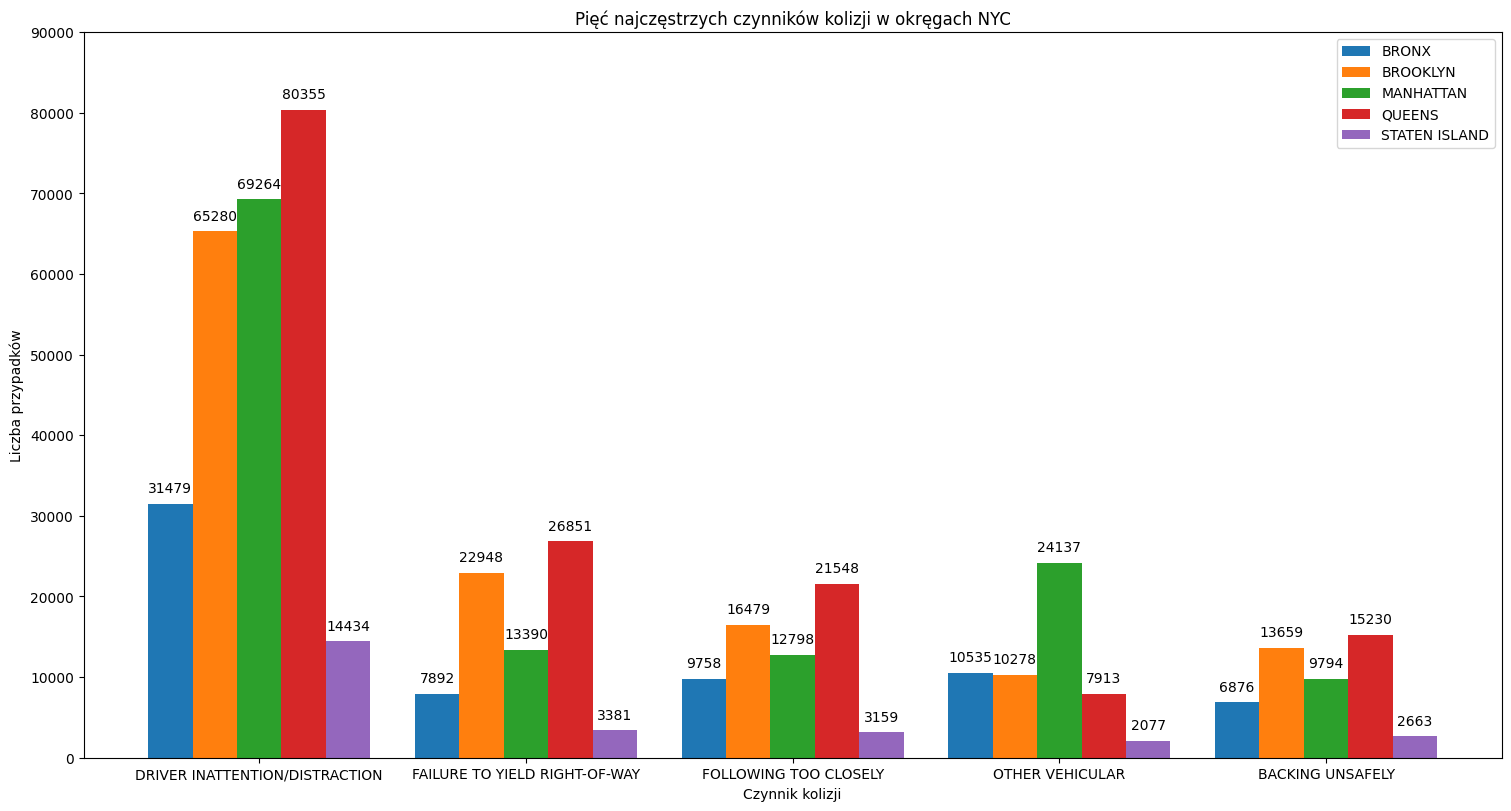

In [44]:
# Wykres pięciu najczęstrzych czynników wypadków w podziale na okręgi NYC
cf_name = contributing_factor_segment.index.to_list()
x = np.arange(len(cf_name))
width = 1/(len(cf_name)+1)
multiplier = 0
fig, ax = plt.subplots(layout='constrained', figsize=(15,8))
for boro in contributing_factor_segment.columns:
    offset = width * multiplier
    rects = ax.bar(x + offset, contributing_factor_segment[boro], width, label=boro)
    ax.bar_label(rects, padding=6);
    multiplier += 1
ax.set_ylabel("Liczba przypadków")
ax.set_xlabel("Czynnik kolizji")
ax.set_title("Pięć najczęstrzych czynników kolizji w okręgach NYC")
# ax.set_xticks(x + 2*width, cf_name, rotation=90)
ax.set_xticks(x + 2*width, cf_name)
ax.legend(loc='upper right', ncols=1)
ax.set_ylim(0, 90000);

**Wnioski:**\
Najczęstrzą przyczyną kolizji/wypadków w NYC dla wszystkich okręgów jest UNSPECIFIED (nieokreślona). Pomijając tę przyczynę kolizji (UNSPECIFIED), druga w kolejności jak widać z wykresu jest DRIVER INATTENTION/DISTRACTION (Nieuwaga / Rozproszenie kierowcy) dla wszystkich okręgów NYC.

In [45]:
# Trzy najważniejsze czynniki kolizji/wypadków w poszczególnych okręgach NYC wraz z częstością ich występowania
# bez czynnika UNSPECIFIED
pie_data = {}
for c in ["BRONX","BROOKLYN","MANHATTAN","QUEENS","STATEN ISLAND","TOTAL"]:
    slc = contributing_factor.loc[contributing_factor.index != "UNSPECIFIED"].sort_values(ascending=False,by=c)[c].head(3)
    pie_data[c]=slc.to_dict()
    pie_data[c]["OTHERS"] = contributing_factor.loc[contributing_factor.index != "UNSPECIFIED"][c].sum()
    display(slc.to_frame())
# pie_data

BRONX
DRIVER INATTENTION/DISTRACTION  31479.0
OTHER VEHICULAR                 10535.0
FOLLOWING TOO CLOSELY            9758.0

BROOKLYN
DRIVER INATTENTION/DISTRACTION   65280.0
FAILURE TO YIELD RIGHT-OF-WAY    22948.0
FOLLOWING TOO CLOSELY            16479.0

MANHATTAN
DRIVER INATTENTION/DISTRACTION    69264.0
OTHER VEHICULAR                   24137.0
FAILURE TO YIELD RIGHT-OF-WAY     13390.0

QUEENS
DRIVER INATTENTION/DISTRACTION  80355.0
FAILURE TO YIELD RIGHT-OF-WAY   26851.0
FOLLOWING TOO CLOSELY           21548.0

STATEN ISLAND
DRIVER INATTENTION/DISTRACTION        14434.0
FAILURE TO YIELD RIGHT-OF-WAY          3381.0
FOLLOWING TOO CLOSELY                  3159.0

TOTAL
DRIVER INATTENTION/DISTRACTION  287419.0
FAILURE TO YIELD RIGHT-OF-WAY    80659.0
FOLLOWING TOO CLOSELY            73566.0

**Wnioski:**\
Z powyższych danych tabelarycznych wynika że najczęstrzymi trzema czynnikami kolizji/wypadków (z pominięciem czynnika UNSPECIFIED) w okręgach NYC są:
- DRIVER INATTENTION/DISTRACTION (nieuwaga/rozproszenie kierowcy), OTHER VEHICULAR (inny pojazd), FOLLOWING TOO CLOSELY (zbyt bliska jazda za innym pojazdem) w okręgu Bronx
- DRIVER INATTENTION/DISTRACTION (nieuwaga/rozproszenie kierowcy), FAILURE TO YIELD RIGHT-OF-WAY (nieudzielenie pierszeństwa przejazdu), FOLLOWING TOO CLOSELY (zbyt bliska jazda za innym pojazdem) w okręgach Brooklyn, Queens i Staten Island
- DRIVER INATTENTION/DISTRACTION (nieuwaga/rozproszenie kierowcy), OTHER VEHICULAR (inny pojazd), FAILURE TO YIELD RIGHT-OF-WAY (nieudzielenie pierszeństwa przejazdu) w okręgu Manhattan

Ogólnie najczęstrzymi określonymi przyczynami kolizji/wypadku w kolejności od najczęstrzej są:
- DRIVER INATTENTION/DISTRACTION (nieuwaga/rozproszenie kierowcy)
- FAILURE TO YIELD RIGHT-OF-WAY (nieudzielenie pierszeństwa przejazdu)
- FOLLOWING TOO CLOSELY (zbyt bliska jazda za innym pojazdem)

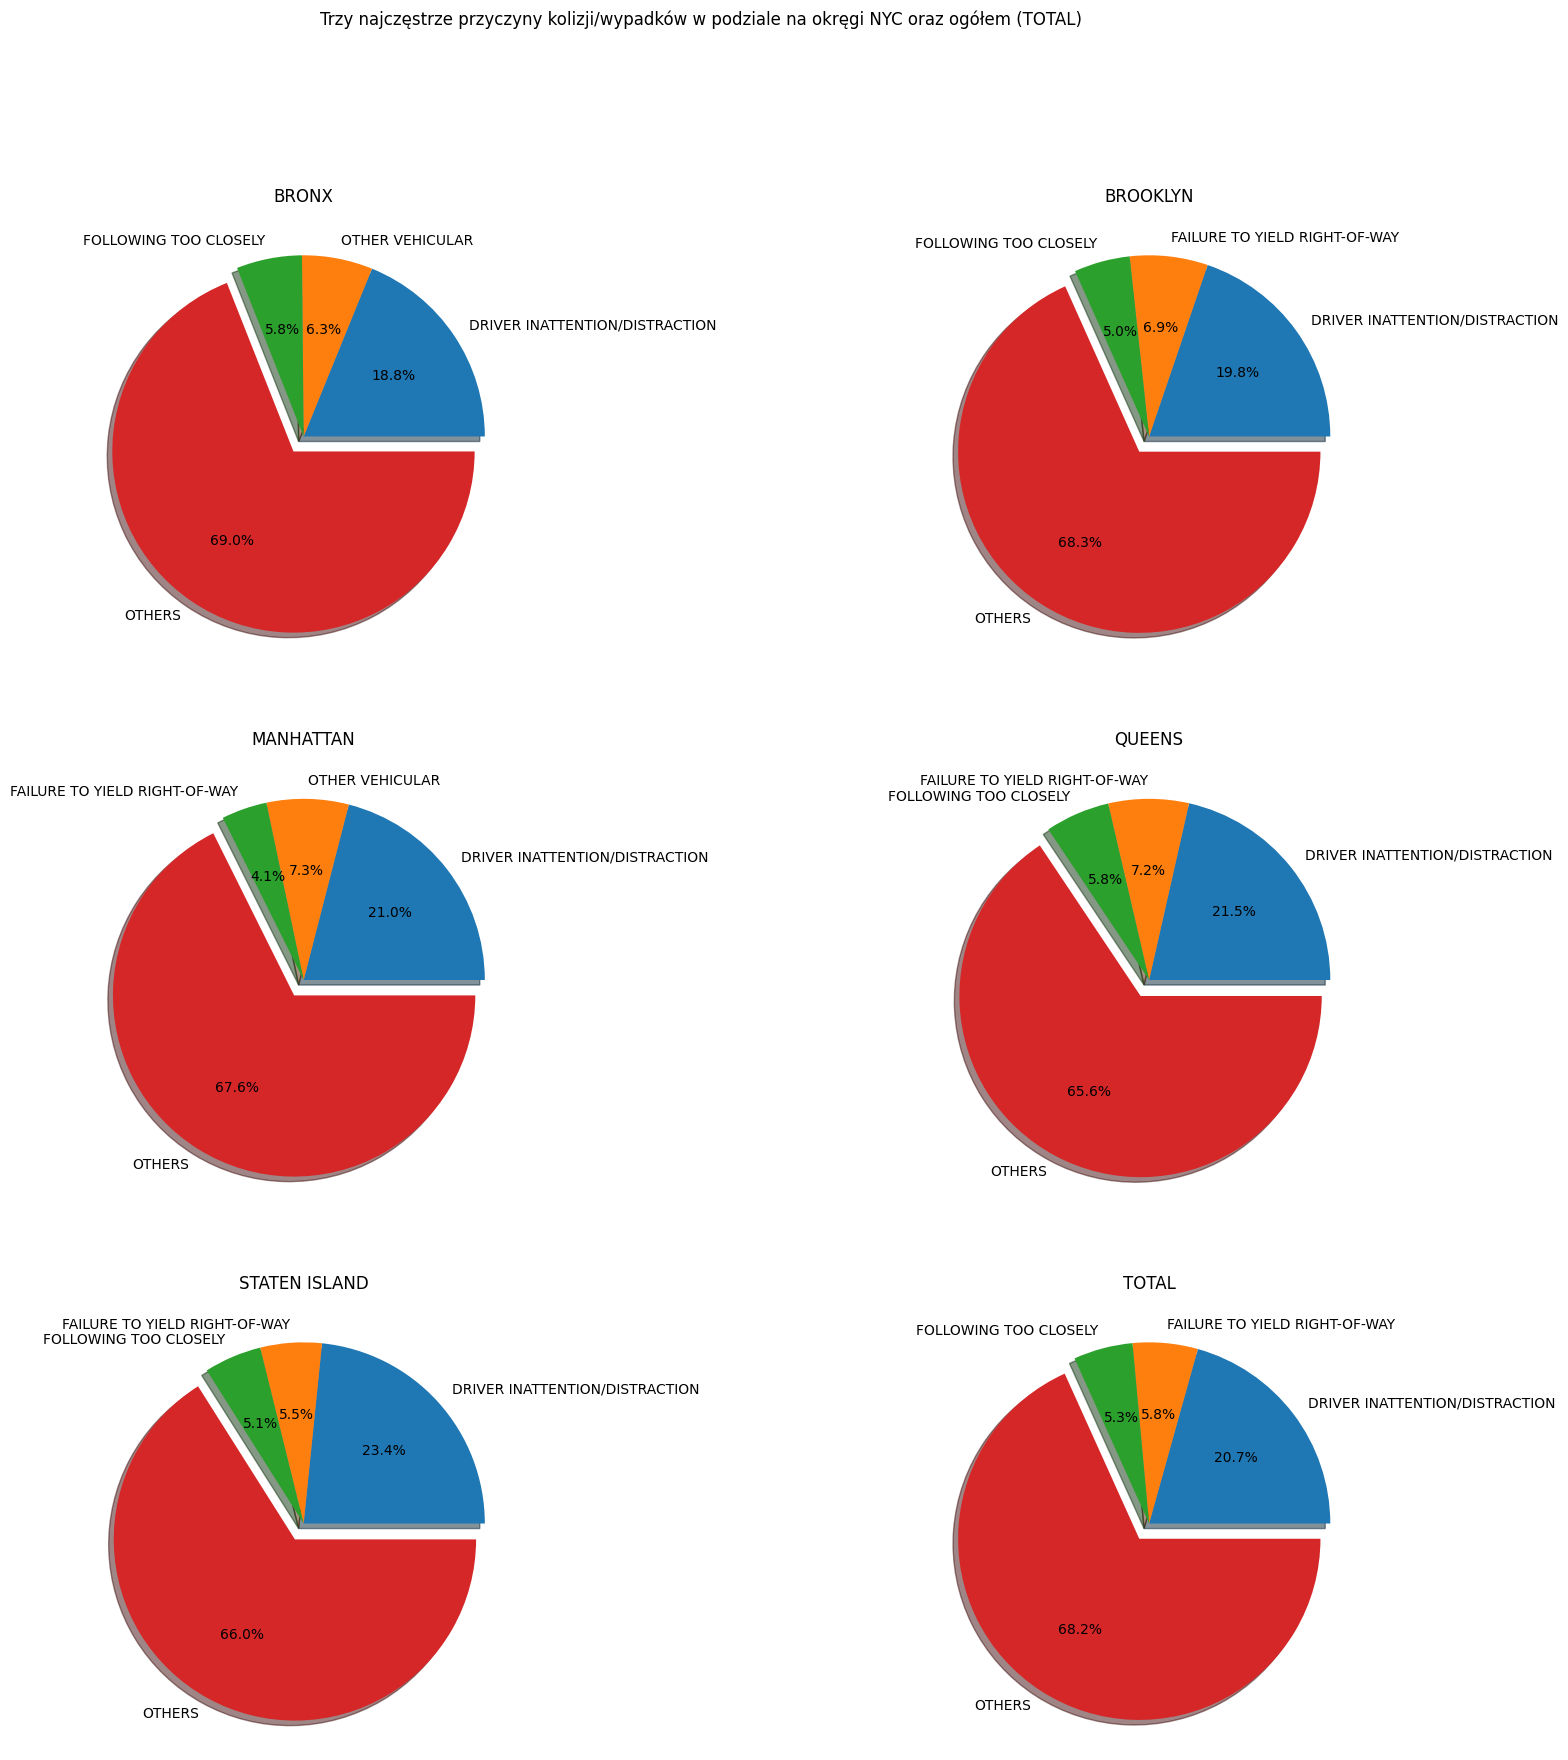

In [46]:
# Wykres trzech najczęstrzych przyczyn wypadków/kolizji w NYC w stosunku do wszystkich innych razem wziętych
fig = plt.figure(figsize=(20,20))
ax = []
for i,boro in enumerate(pie_data):
    ax.append(fig.add_subplot(3,2,i+1))
    ax[i].pie(pie_data[boro].values(),labels=pie_data[boro].keys(),autopct='%1.1f%%',explode=(0,0,0,0.1),shadow=True)
    ax[i].set_title(boro)
fig.suptitle("Trzy najczęstrze przyczyny kolizji/wypadków w podziale na okręgi NYC oraz ogółem (TOTAL)");

#### Ilość zgonów oraz rannych spowodowanych zbyt szybką jazdą w poszczególnych okręgach NYC oraz ogółem.

Kolizje/wypadki będą reprezentowane przez czynnik o nazwie "UNSAFE SPEED".

In [47]:
# Liczba zabitych i rannych spowodowanych czynnikiem "UNSAFE SPEED" (Niebezpieczna prędkość)
killed = nyc_collisions.loc[nyc_collisions["CONTRIBUTING_FACTORS"].str.count("UNSAFE SPEED") > 0].groupby("BOROUGH")["NUMBER OF PERSONS KILLED"].sum()
injured = nyc_collisions.loc[nyc_collisions["CONTRIBUTING_FACTORS"].str.count("UNSAFE SPEED") > 0].groupby("BOROUGH")["NUMBER OF PERSONS INJURED"].sum()
killed_injured_speed = pd.concat([killed,injured],axis=1).T
killed_injured_speed.index.name = 'UNSAFE SPEED'
killed_injured_speed["TOTAL"] = killed_injured_speed.sum(axis=1)
killed_injured_speed

BOROUGH                         BRONX  BROOKLYN  MANHATTAN  QUEENS  \
UNSAFE SPEED                                                         
NUMBER OF PERSONS KILLED    10     18        23         10      47   
NUMBER OF PERSONS INJURED  672   1595      2116        726    2328   

BOROUGH                    STATEN ISLAND  TOTAL  
UNSAFE SPEED                                     
NUMBER OF PERSONS KILLED              12    120  
NUMBER OF PERSONS INJURED            437   7874

**Liczba zabitych i rannych w których jednym z czynników wypadku była zbyt szybka jazda.**\
Kolumna *UNKNOWN* reprezentuje dane które nie udało się przydzielić do żadnych z okręgów (problematyczne dane).

**Wniosek:**\
Najniebezpieczniejszymi okręgami pod względem zbyt szybkiej jazdy są okręgi Queens i Brooklin. Liczba zabitych i rannych z powodu zbyt szybkiej jazdy była w tych okręgach największa.

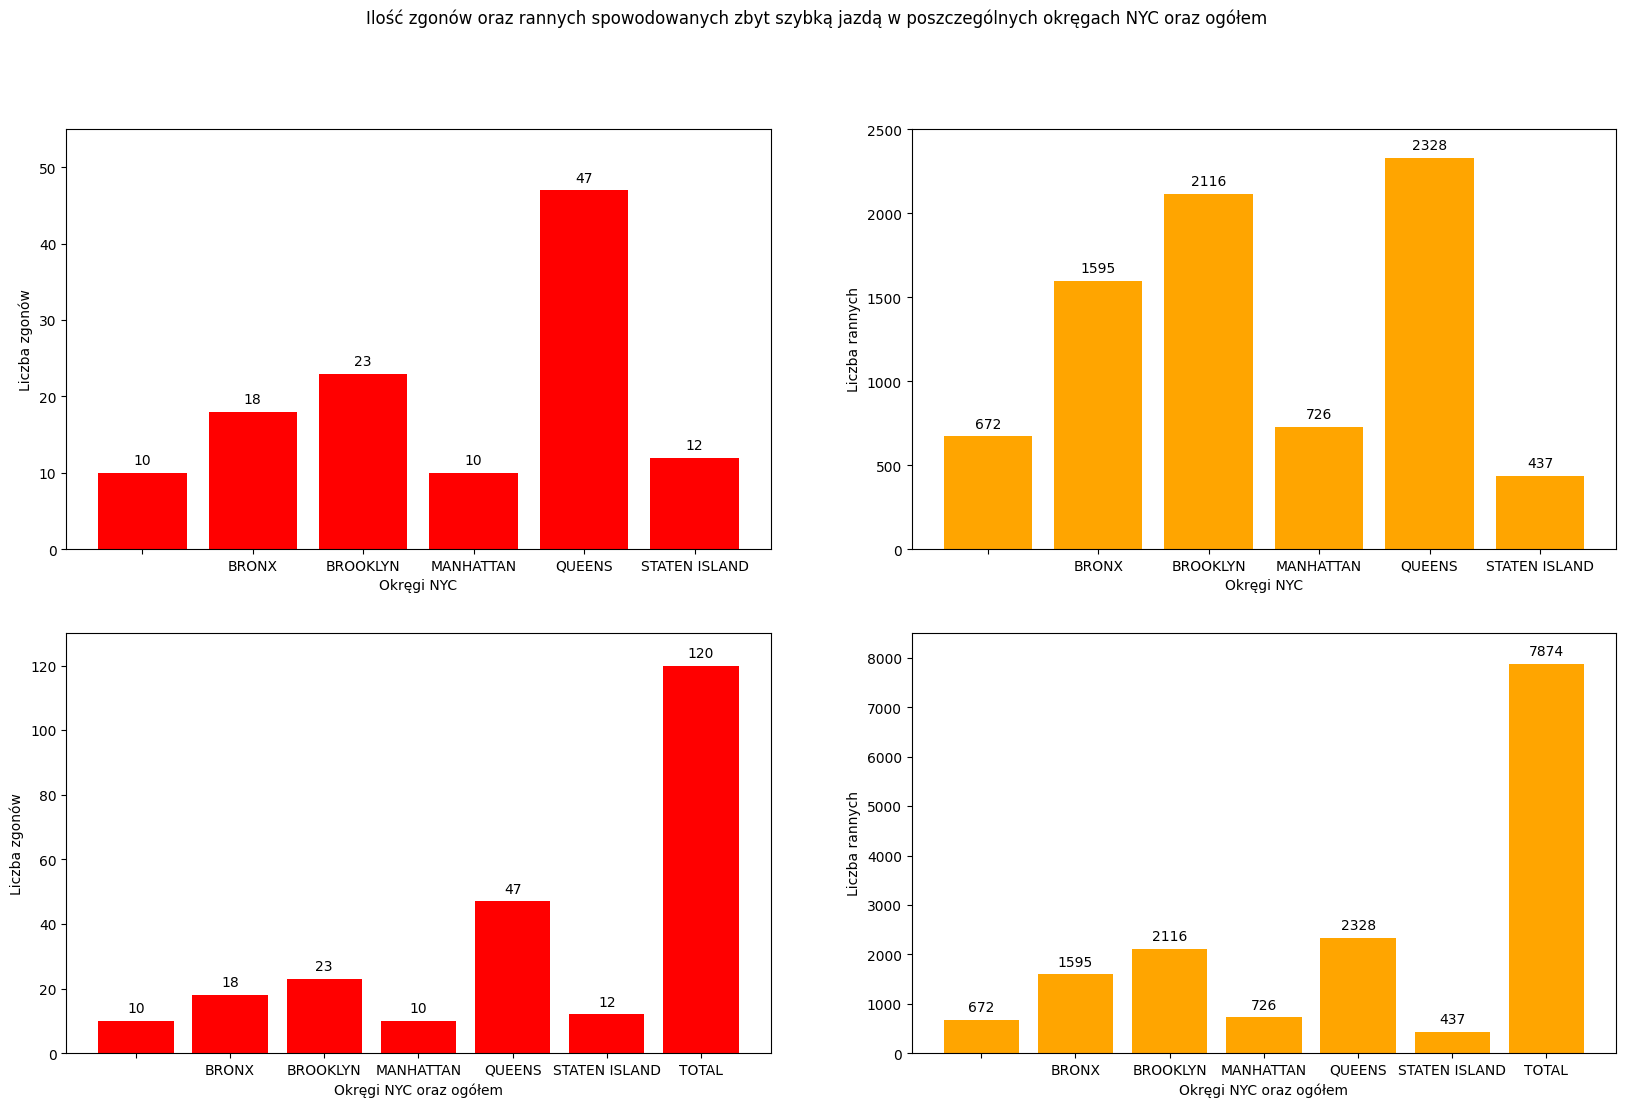

In [48]:
# Okręgami zabici
boro = killed_injured_speed.columns.to_list()[:-1]
fig = plt.figure(figsize=(20,12))
ax1 = fig.add_subplot(2,2,1)
# ax1.bar(boro,kj.loc["KILLED"][1:],color="red")
p = ax1.bar(boro,killed_injured_speed.loc["NUMBER OF PERSONS KILLED"][:-1],color="red")
ax1.bar_label(p,padding=4)
ax1.set_ylabel("Liczba zgonów")
ax1.set_xlabel("Okręgi NYC")
ax1.set_ylim(0, 55);
# Okręgami ranni
ax2 = fig.add_subplot(2,2,2)
# ax2.bar(boro,kj.loc["INJURED"][1:],color="orange")
p = ax2.bar(boro,killed_injured_speed.loc["NUMBER OF PERSONS INJURED"][:-1],color="orange")
ax2.bar_label(p,padding=4)
ax2.set_ylim(0, 2500);
ax2.set_ylabel("Liczba rannych")
ax2.set_xlabel("Okręgi NYC")
# Ogółem zabici
boro = killed_injured_speed.columns.to_list()
ax3 = fig.add_subplot(2,2,3)
p = ax3.bar(boro,killed_injured_speed.loc["NUMBER OF PERSONS KILLED"],color="red")
ax3.bar_label(p,padding=4)
ax3.set_ylabel("Liczba zgonów")
ax3.set_xlabel("Okręgi NYC oraz ogółem")
ax3.set_ylim(0, 130);
# Ogółem ranni
ax4 = fig.add_subplot(2,2,4)
p = ax4.bar(boro,killed_injured_speed.loc["NUMBER OF PERSONS INJURED"],color="orange")
ax4.bar_label(p,padding=4)
ax4.set_ylabel("Liczba rannych")
ax4.set_xlabel("Okręgi NYC oraz ogółem")
ax4.set_ylim(0, 8500)
fig.suptitle("Ilość zgonów oraz rannych spowodowanych zbyt szybką jazdą w poszczególnych okręgach NYC oraz ogółem");

In [49]:
# Liczba osób rannych w poszczególnych okręgach w podziale na lata
injured_boro_by_year = nyc_collisions.loc[(nyc_collisions["ACCIDENT DATE"].dt.year > 2012) & (nyc_collisions["ACCIDENT DATE"].dt.year < 2019)].groupby([nyc_collisions["ACCIDENT DATE"].dt.year,"BOROUGH"])["NUMBER OF PERSONS INJURED"].sum().to_frame().unstack()
injured_boro_by_year = injured_boro_by_year.rename(columns={'':'UNKNOWN'})
injured_boro_by_year[('NUMBER OF PERSONS INJURED',"TOTAL")] = injured_boro_by_year.sum(axis=1)
injured_boro_by_year

NUMBER OF PERSONS INJURED                                  \
BOROUGH                         UNKNOWN BRONX BROOKLYN MANHATTAN QUEENS   
ACCIDENT DATE                                                             
2013                               5691  4728    11125      5693   8899   
2014                               5982  4868    11828      5841   9477   
2015                               5700  4509    10675      5228   9615   
2016                               4706  6879    13557      6521  12293   
2017                               2848  7484    13365      6507  12497   
2018                               3161  8347    15302      6631  13998   

                                    
BOROUGH       STATEN ISLAND  TOTAL  
ACCIDENT DATE                       
2013                   1719  37855  
2014                   1373  39369  
2015                   1304  37031  
2016                   1902  45858  
2017                   2146  44847  
2018                   2238  49677

**Liczba rannych w pełnych latach w podziale na okręgi**\
Dane obejmują pełne lata od 2013 do 2018 wszystkich wypadków/kolizji. Kolumna *UNKNOWN* to dane, których nie można było przyporządkować do żadnego okręgu NYC.

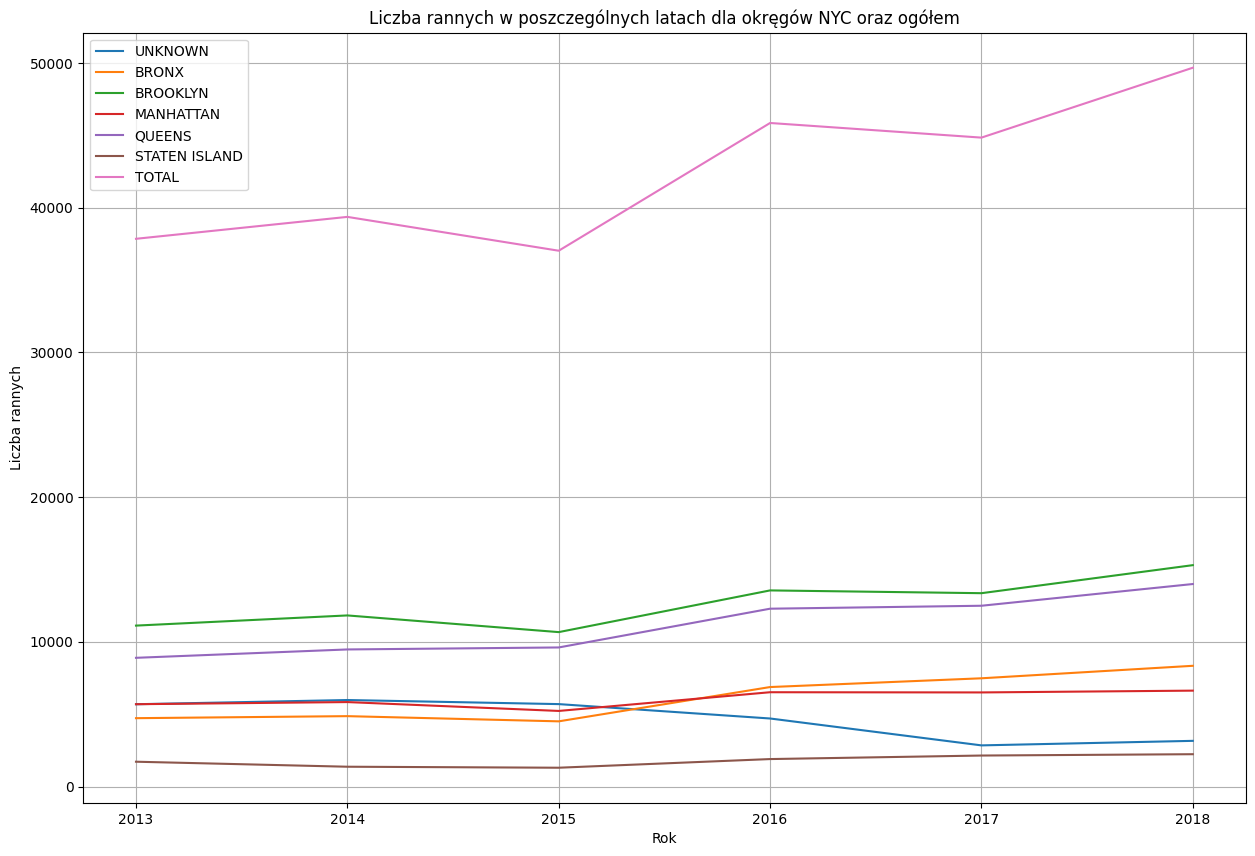

In [50]:
# Wykres liczby rannych w podziale na lata i okręgi NYC
fig,ax = plt.subplots(figsize=(15,10))
for col in injured_boro_by_year:
    ax.plot(injured_boro_by_year.index,injured_boro_by_year[col],label=col[1])
ax.legend()
ax.set_title("Liczba rannych w poszczególnych latach dla okręgów NYC oraz ogółem")
ax.set_ylabel("Liczba rannych")
ax.set_xlabel("Rok")
plt.grid()
plt.show()

In [51]:
# Liczba osób zabitych w poszczególnych okręgach w podziale na lata
killed_boro_by_year = nyc_collisions.loc[(nyc_collisions["ACCIDENT DATE"].dt.year > 2012) & (nyc_collisions["ACCIDENT DATE"].dt.year < 2019)].groupby([nyc_collisions["ACCIDENT DATE"].dt.year,"BOROUGH"])["NUMBER OF PERSONS KILLED"].sum().to_frame().unstack()
killed_boro_by_year = killed_boro_by_year.rename(columns={'':'UNKNOWN'})
killed_boro_by_year[('NUMBER OF PERSONS KILLED',"TOTAL")] = killed_boro_by_year.sum(axis=1)
killed_boro_by_year

NUMBER OF PERSONS KILLED                                  \
BOROUGH                        UNKNOWN BRONX BROOKLYN MANHATTAN QUEENS   
ACCIDENT DATE                                                            
2013                                36    27       45        33     55   
2014                                35    15       55        32     59   
2015                                31    23       43        16     42   
2016                                20    35       39        34     46   
2017                                15    27       43        42     52   
2018                                 7    28       54        24     63   

                                   
BOROUGH       STATEN ISLAND TOTAL  
ACCIDENT DATE                      
2013                      3   199  
2014                      8   204  
2015                     13   168  
2016                     13   187  
2017                     13   192  
2018                      8   184

**Liczba zabitych w pełnych latach w podziale na okręgi**\
Dane obejmują pełne lata od 2013 do 2018 wszystkich wypadków/kolizji. Kolumna *UNKNOWN* to dane, których nie można było przyporządkować do żadnego okręgu NYC.

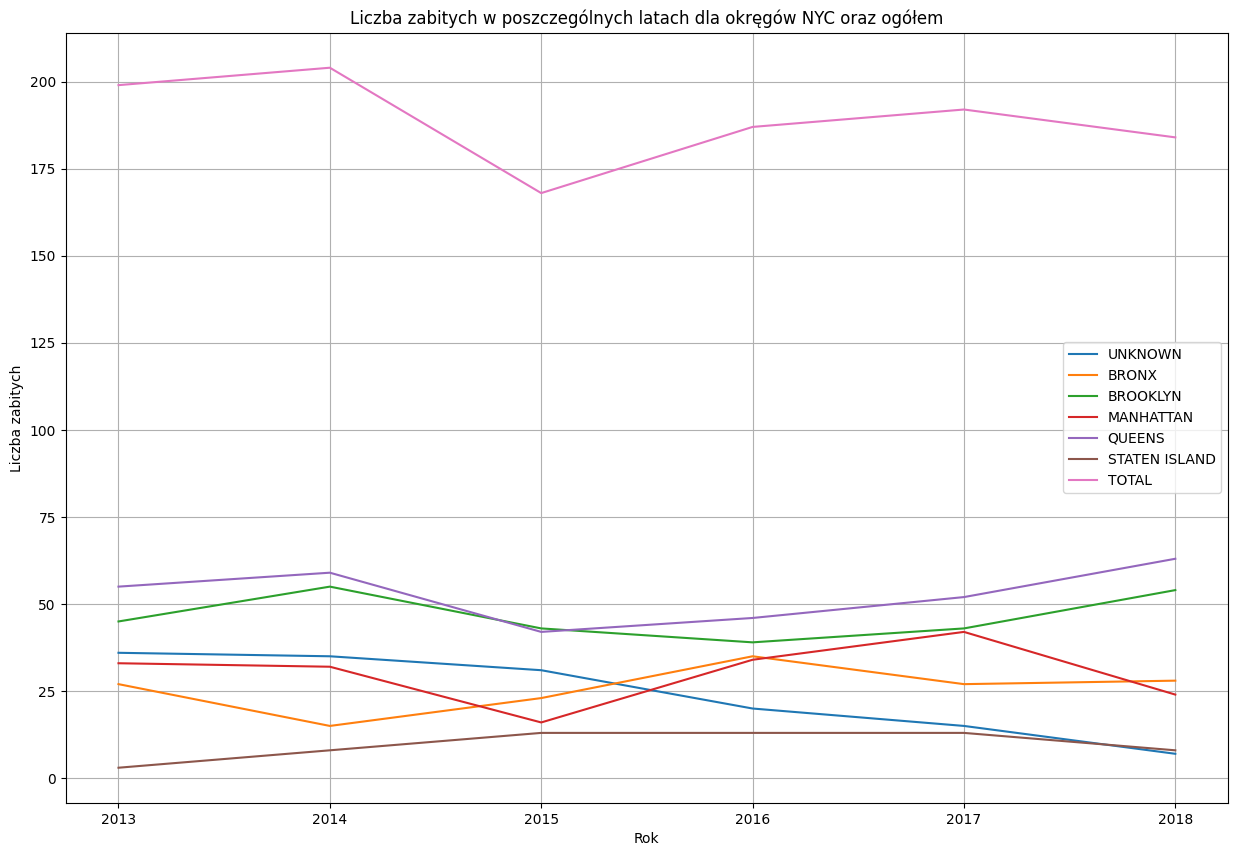

In [52]:
# Liczba zabitych w podziale na lata i okręgi NYC
fig,ax = plt.subplots(figsize=(15,10))
for col in killed_boro_by_year:
    ax.plot(killed_boro_by_year.index,killed_boro_by_year[col],label=col[1])
ax.legend()
ax.set_title("Liczba zabitych w poszczególnych latach dla okręgów NYC oraz ogółem")
ax.set_ylabel("Liczba zabitych")
ax.set_xlabel("Rok")
plt.grid()
plt.show()

**Wnioski:**\
Okręgiem przodującym zarówno w liczbie osób zabitych jak i rannych w wyniku zbyt szybkiej jazdy jest okręg Queens drugie miejsce zajmuje Brooklyn.
Całościowo bez względu na czynnik wypadku/kolizji w liczbie rannych przoduje okręg Brooklyn, natomiast w liczbie zabitych okręg Queens. Ogólnie liczba zabitych w wypadkach ma tendencję spadkową.

#### Określenie jakie pojazdy najczęściej uczestniczyły w wypadkach

In [53]:
cols = ['VEHICLE TYPE CODE 1','VEHICLE TYPE CODE 2','VEHICLE TYPE CODE 3','VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5']
vehicles = count_value_by_group(nyc_collisions,"BOROUGH",cols)
vehicles.sort_index(inplace=True)
# vehicles.sort_values(ascending=False,by="TOTAL")
# vehicles.sort_values(ascending=False,by="TOTAL")

In [54]:
# Wykres dla pięciu typów pojazdów uczestniczących w kolizji
rows = ["PASSENGER VEHICLE","SPORT UTILITY / STATION WAGON","SEDAN","STATION WAGON/SPORT UTILITY VEHICLE","TAXI"]
cols = ["UNKNOWN","BRONX","BROOKLYN","MANHATTAN","QUEENS","STATEN ISLAND","TOTAL"]
vehicles_top_5 = vehicles.loc[rows,cols]
vehicles_top_5

UNKNOWN     BRONX  BROOKLYN  MANHATTAN  \
PASSENGER VEHICLE                    126741.0  123222.0  262067.0   160556.0   
SPORT UTILITY / STATION WAGON         52098.0   52095.0  122062.0    75038.0   
SEDAN                                 15771.0   36195.0   66854.0    35804.0   
STATION WAGON/SPORT UTILITY VEHICLE   13013.0   27589.0   53789.0    28613.0   
TAXI                                   6237.0    6944.0   10090.0    64081.0   

                                       QUEENS  STATEN ISLAND     TOTAL  
PASSENGER VEHICLE                    262743.0        50580.0  985909.0  
SPORT UTILITY / STATION WAGON        131065.0        22332.0  454690.0  
SEDAN                                 66916.0        10818.0  232358.0  
STATION WAGON/SPORT UTILITY VEHICLE   61467.0         7903.0  192374.0  
TAXI                                  10609.0          194.0   98155.0

**Częstość wypadków/kolizji po typach pojazdów w poszczególnych okręgach NYC**\
Kolumna *UNKNOWN* to dane których nie można było przyporządkować do żadnego okręgu NYC.

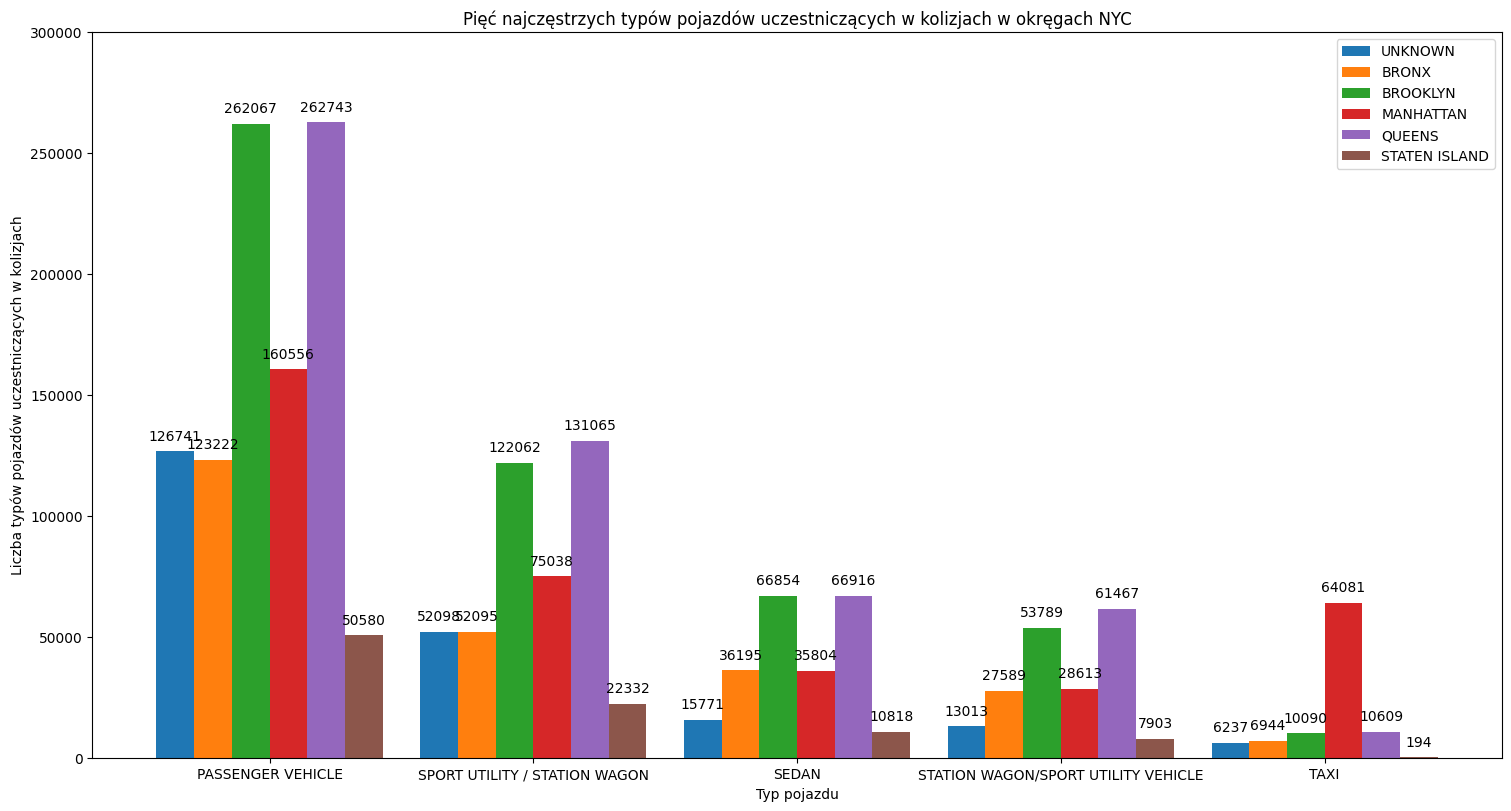

In [55]:
# Pięć najczęstrzych typów pojazdów uczestniczących w kolizjach w okręgach NYC
vhc = vehicles_top_5.index.to_list()
x = np.arange(len(vhc))
width = 1/7
multiplier = 0
fig, ax = plt.subplots(layout='constrained', figsize=(15,8))
for boro in vehicles_top_5.columns[:-1]:
    offset = width * multiplier
    rects = ax.bar(x + offset, vehicles_top_5[boro], width, label=boro)
    ax.bar_label(rects, padding=6);
    multiplier += 1
ax.set_ylabel("Liczba typów pojazdów uczestniczących w kolizjach")
ax.set_xlabel("Typ pojazdu")
ax.set_title("Pięć najczęstrzych typów pojazdów uczestniczących w kolizjach w okręgach NYC")
ax.set_xticks(x + 2.5*width, vhc)
ax.legend(loc='upper right', ncols=1)
ax.set_ylim(0, 300000);

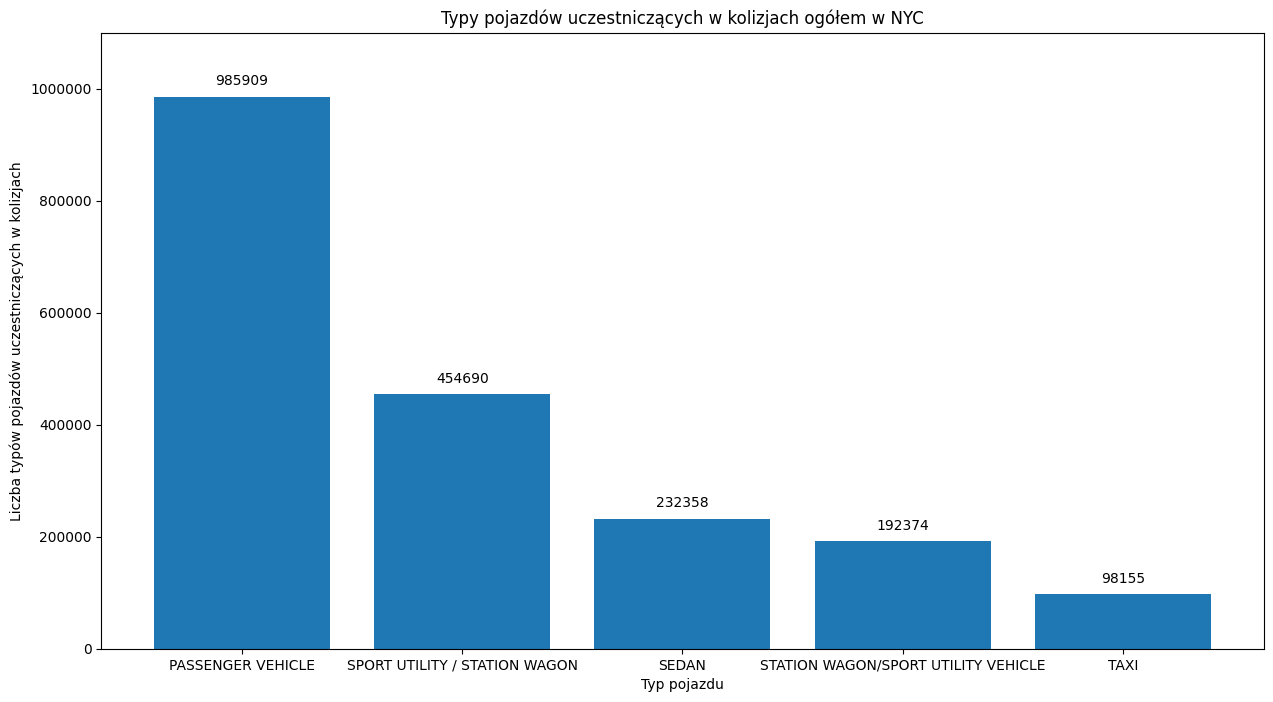

In [56]:
# Całkowita liczba przypadków kolizji po 5 naczęściej występujących typach pojazdów
fig, ax = plt.subplots(figsize=(15,8))
p = ax.bar(vehicles_top_5.index.to_list(),vehicles_top_5["TOTAL"])
ax.bar_label(p, padding=6)
ax.set_ylabel("Liczba typów pojazdów uczestniczących w kolizjach")
ax.set_xlabel("Typ pojazdu")
ax.set_title("Typy pojazdów uczestniczących w kolizjach ogółem w NYC");
ax.ticklabel_format(style='plain',axis='y')
ax.set_ylim(0, 1_100_000);

**Wnioski:**\
Najczęstrzym typem samochodu uczystniczącym w kolizjach/wypadkach jest samochód osobowy.\
Niestety brak słownika z typami smaochodów uniemożliwia rzetelną analizę, przykładem jest typ pojazdu *SPORT UTILITY / STATION WAGON* i *STATION WAGON/SPORT UTILITY VEHICLE* który prawdopodobnie dotyczy tego samego typu pojazdu.

#### Analiza danych oparta na lokalizacji geogeaficznej.

Analiza danych w oparciu o lokalizacje geograficzne, opiera się na wycinku danych, które udało się przyporządkować do obszarów lub sąsiedztw.

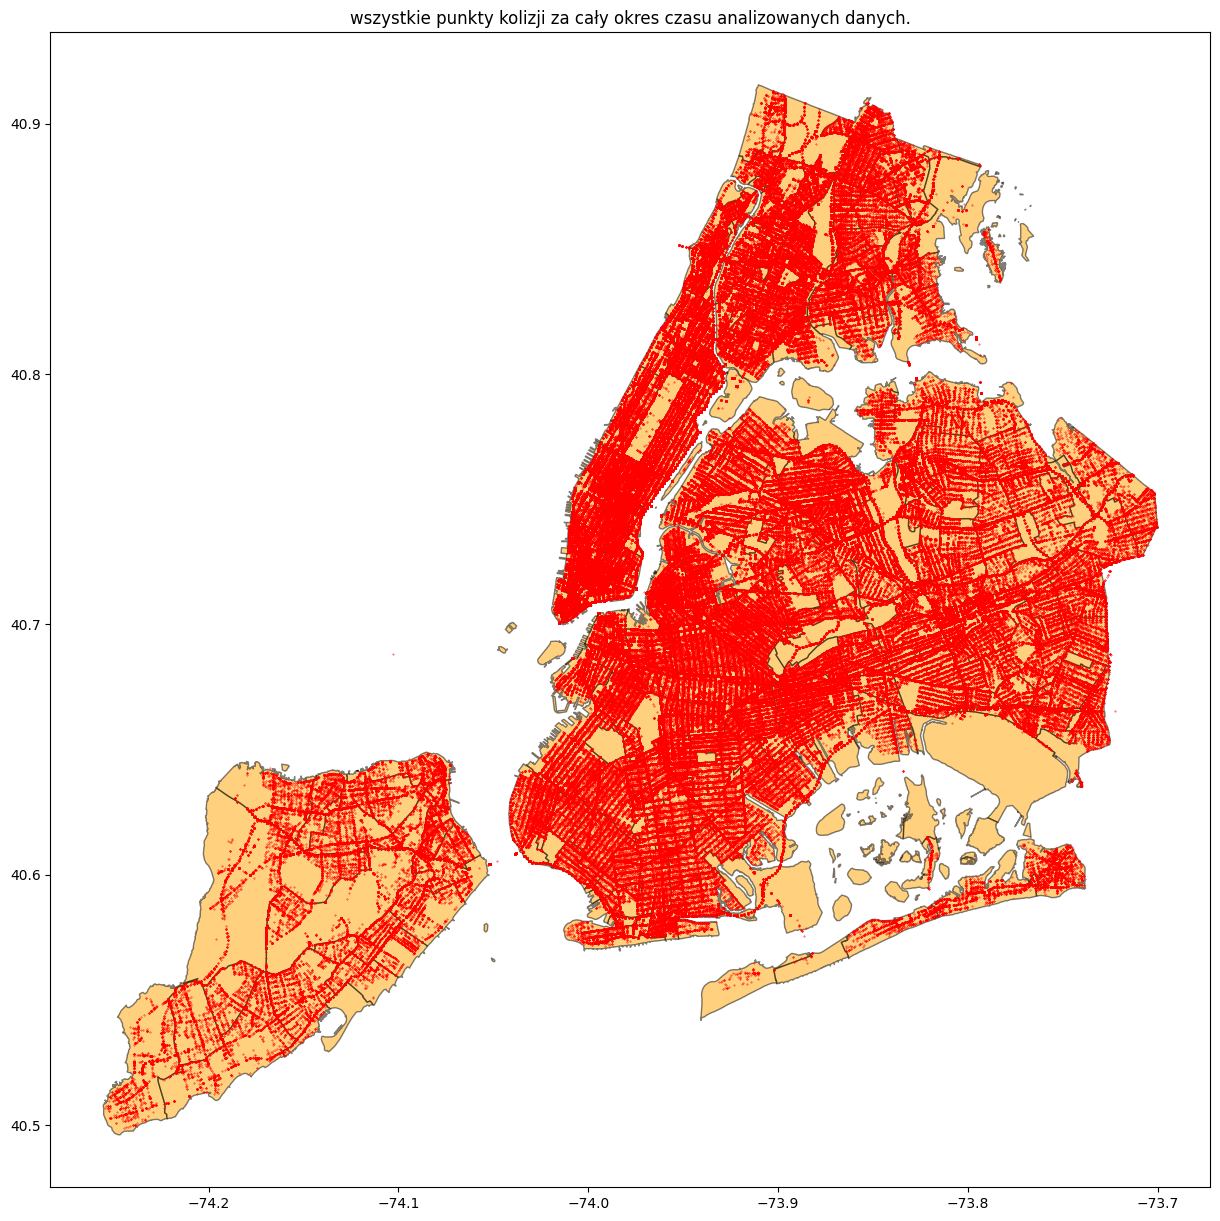

In [57]:
# Kolizje które posiadają prawidłową lokalizację w NYC
# Cały zakres dat
fig,ax = plt.subplots(1,1, figsize=(15,15))
ax.set_title("wszystkie punkty kolizji za cały okres czasu analizowanych danych.")
base = neighborhood.plot(color="orange",alpha=0.5,edgecolor='black',ax=ax)
gis_nyc_collisions.loc[gis_nyc_collisions["LocationNYC"]].plot(ax=base, color="red", markersize=0.1);

Z wykresu powyżej widać, że kolizje wydarzają się praktycznie w każdym miejscu miasta Nowy Jork gdzie znajdują się ulice. Duże zagęszczenie  punktów kolizji np. w okręgu Manhattan, a dużo mniesze w okręgu Staten Island, co pokrywa z zaludniem tych okręgów (dużo mniejsze na Staten Island niż na Manhattan).

#### Obszary okręgów NYC, gdzie kolizje występowały najczęściej

In [58]:
# 10 pierwszych obszarów miasta Nowy Jork w którym kolizje występują najczęściej
# Uwzględniam tylko kolizje z przypisaną lokalizacją geograficzną do dowolnego obszaru miasta Nowy Jork
# za cały okres czasu.
# geo_collisions.loc[~geo_collisions["NTACode"].isna()].groupby("NTACode")["COLLISION_ID"].count().sort_values(ascending=False).head(10)
nta_collisions = gis_nyc_collisions.loc[~gis_nyc_collisions["NTACode"].isna()].groupby("NTACode")["COLLISION_ID"].count().sort_values(ascending=False)
nta_collisions.name = "Count"
# nta_collisions.head(10)
neighborhood[["NTACode","BoroCode","BoroName","neighbourhood"]].merge(nta_collisions,on="NTACode").sort_values("Count", ascending=False).head(10)

NTACode  BoroCode   BoroName                               neighbourhood  \
80     MN17         1  MANHATTAN                       Midtown-Midtown South   
104    MN13         1  MANHATTAN  Hudson Yards-Chelsea-Flatiron-Union Square   
136    BK82         3   BROOKLYN                               East New York   
171    QN99         4     QUEENS                    park-cemetery-etc-Queens   
117    QN31         4     QUEENS        Hunters Point-Sunnyside-West Maspeth   
108    MN24         1  MANHATTAN      SoHo-TriBeCa-Civic Center-Little Italy   
68     BK61         3   BROOKLYN                         Crown Heights North   
51     MN19         1  MANHATTAN                     Turtle Bay-East Midtown   
105    MN15         1  MANHATTAN                                     Clinton   
1      QN55         4     QUEENS                            South Ozone Park   

     Count  
80   25962  
104  20577  
136  17907  
171  17656  
117  17089  
108  15879  
68   15162  
51   12611  
105  12014  
1    11953

**Dziesięć sąsiedztw w których doszło do największej liczby wypadków/kolizji.**\
Kolumna *BoroName* określa nazwę okręgu, *neighbourhood* nazwę sąsiedztwa w okręgu, a *Count* liczbę kolizji w sąsiedztwie.\
Przodują trzy okręgi Manhattan, Brooklyn i Queens

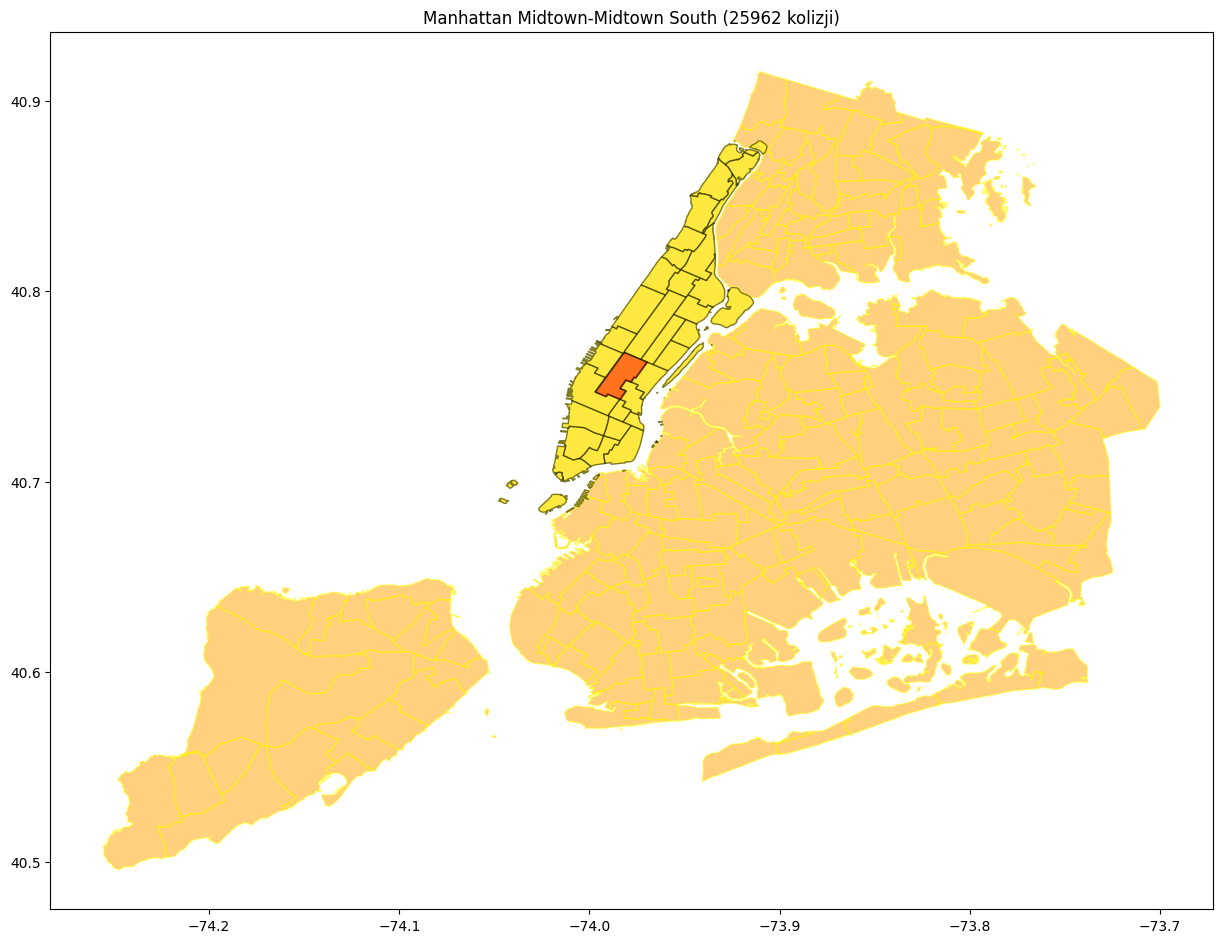

In [59]:
# Gdzie na mapie miasta Nowy Jork znajduje się Midtown-Midtown South w dzielnicy Manhattan z największą liczbą kolizji
# za cały okres czasowy danych. 25962 kolizji
fig, ax = plt.subplots(1,1,figsize=(15,15))
ax.set_title("Manhattan Midtown-Midtown South (25962 kolizji)")
nyc = neighborhood.plot(color="orange",alpha=0.5,edgecolor='yellow',label="New York",ax=ax)
manhattan = neighborhood.loc[neighborhood["BoroCode"] == 1].plot(color="yellow",alpha=0.5,edgecolor='black',label="Manhattan",ax=nyc)
mn17 = neighborhood.loc[neighborhood["NTACode"] == "MN17"].plot(color="red",alpha=0.5,edgecolor='black',label="Midtown-Midtown South",ax=manhattan);
# plt.savefig("manhattan.png")

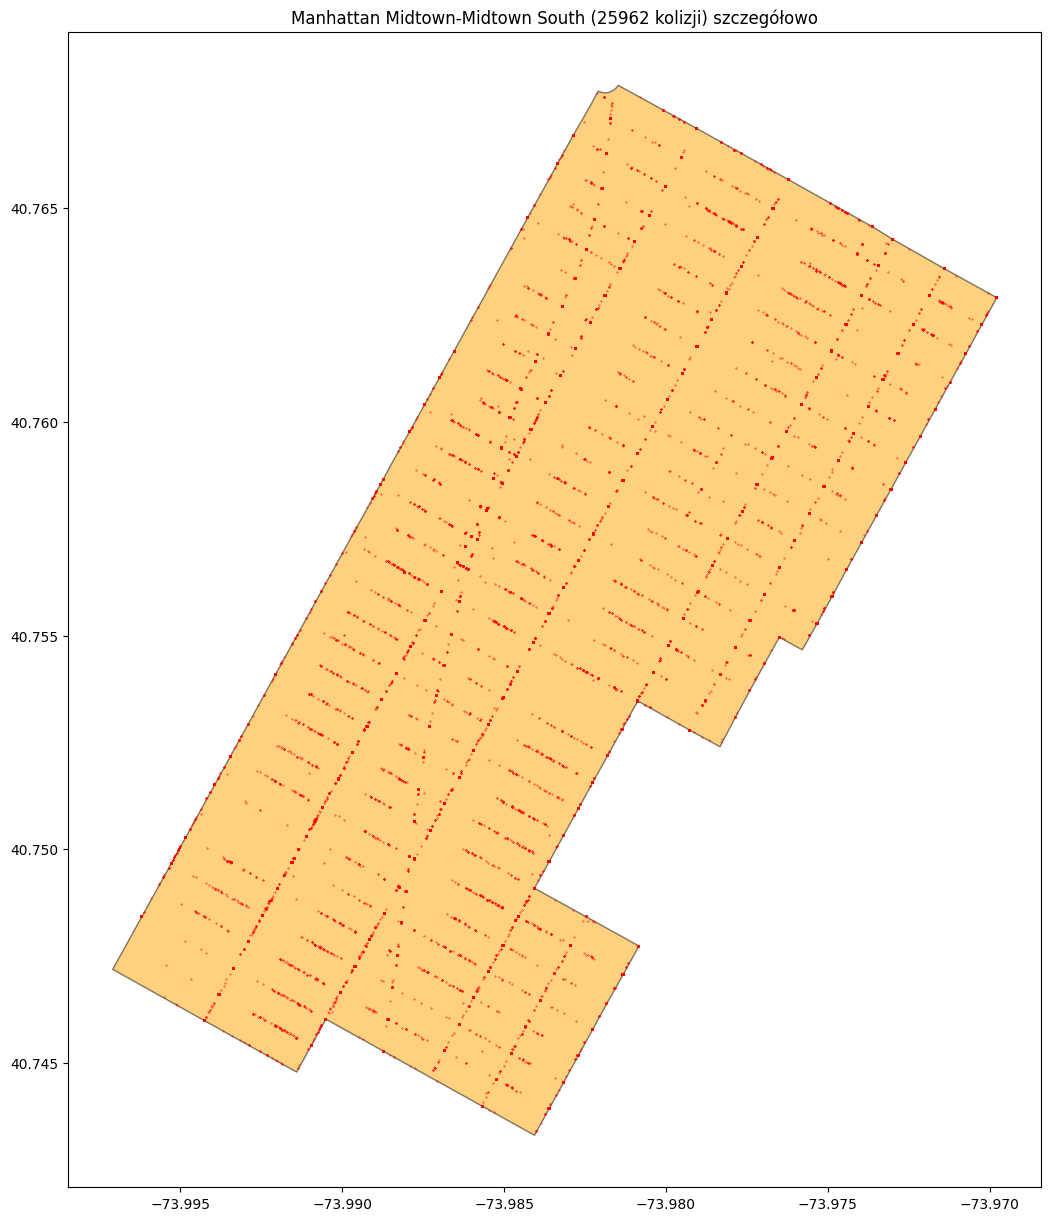

In [60]:
# Kolizje za cały okres czasu w  Midtown-Midtown South w dzielnicy Manhattan w szczegółach
fig,ax = plt.subplots(1,1, figsize=(15,15))
ax.set_title("Manhattan Midtown-Midtown South (25962 kolizji) szczegółowo")
mn17 = neighborhood.loc[neighborhood["NTACode"]=='MN17'].plot(color="orange",alpha=0.5,edgecolor='black',ax=ax)
gis_nyc_collisions.loc[gis_nyc_collisions["NTACode"]=='MN17'].plot(ax=mn17, color="red", markersize=0.1);

Kolizje układają się w zarys ulic. Ulica biegnąca w poprzek obszaru Midtown-Midtown South (północ-południe) to brodway.

#### Liczba kolizji w podziale na obszary i okręgi NYC.

W analize uwwzględniono tylko kolizje przyporządkowane po lokalizacji geograficznej do dowolnego obszaru miasta Nowy Jork.

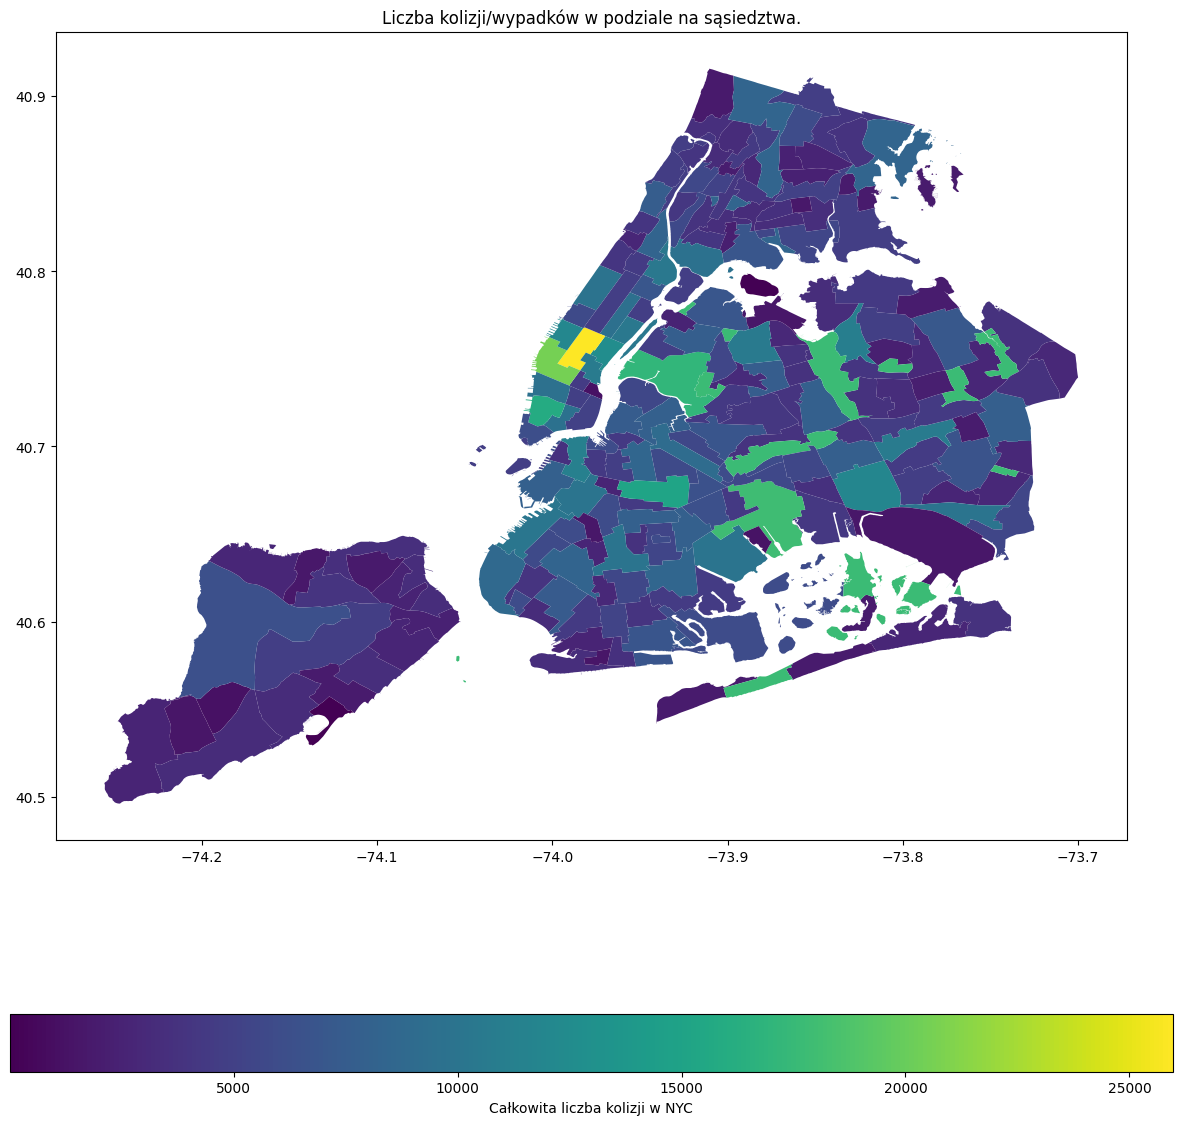

In [61]:
# Liczba kolizji w podziale na obszary miasta NYC, cały dostępny zakres dat
fig,ax = plt.subplots(1,1, figsize=(15,15))
neighborhood.merge(nta_collisions,on="NTACode").plot(column="Count", legend=True, legend_kwds={"label": "Całkowita liczba kolizji w NYC", "orientation": "horizontal"}, ax=ax)
ax.set_title("Liczba kolizji/wypadków w podziale na sąsiedztwa.");

#### Liczba kolizji w podziale na okręgi NYC

Najwięcej kolizji wydarzyło się w okręgu Brooklyn.

In [62]:
# Liczba kolizji w podziale na obszary NYC
boro_collisions = nyc_collisions.loc[nyc_collisions["BOROUGH"].str.len() > 0].groupby("BOROUGH")["COLLISION_ID"].count().sort_values(ascending=False)
boro_collisions.name = "Count"
boro_collisions = boro_collisions.reset_index()
# boro_collisions.to_frame().merge(boroughs[["BoroName","BoroCode"]],on="BoroCode")[["BoroName","Count"]]
boro_collisions

BOROUGH   Count
0       BROOKLYN  321508
1         QUEENS  310050
2      MANHATTAN  246998
3          BRONX  155334
4  STATEN ISLAND   53648

**Liczba kolizji w podziale na okręgi miasta Nowy Jork**

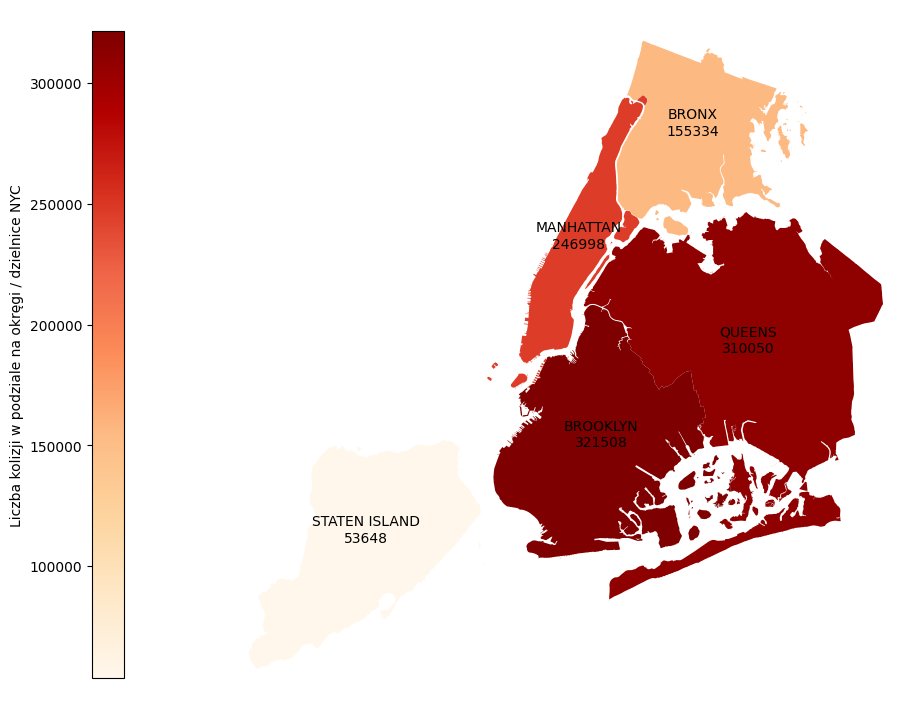

In [63]:
fig, ax = plt.subplots(1,1,figsize=(12,12))
boroughs.merge(boro_collisions,left_on="BoroName",right_on="BOROUGH").plot(column="Count", legend=True, cmap="OrRd", legend_kwds={"label": "Liczba kolizji w podziale na okręgi / dzielnice NYC", "orientation": "vertical", "location": "left", "shrink": 0.7}, ax=ax)
boroughs.merge(boro_collisions,left_on="BoroName",right_on="BOROUGH").apply(lambda x: ax.annotate(text=x.BoroName+"\n"+str(x.Count), color='black', xy=x.geometry.centroid.coords[0],ha='center'), axis=1)
plt.axis("off");

In [64]:
del(boro_collisions)

#### Liczba rannych w kolizjach w podziale na obszary i okręgi NYC.

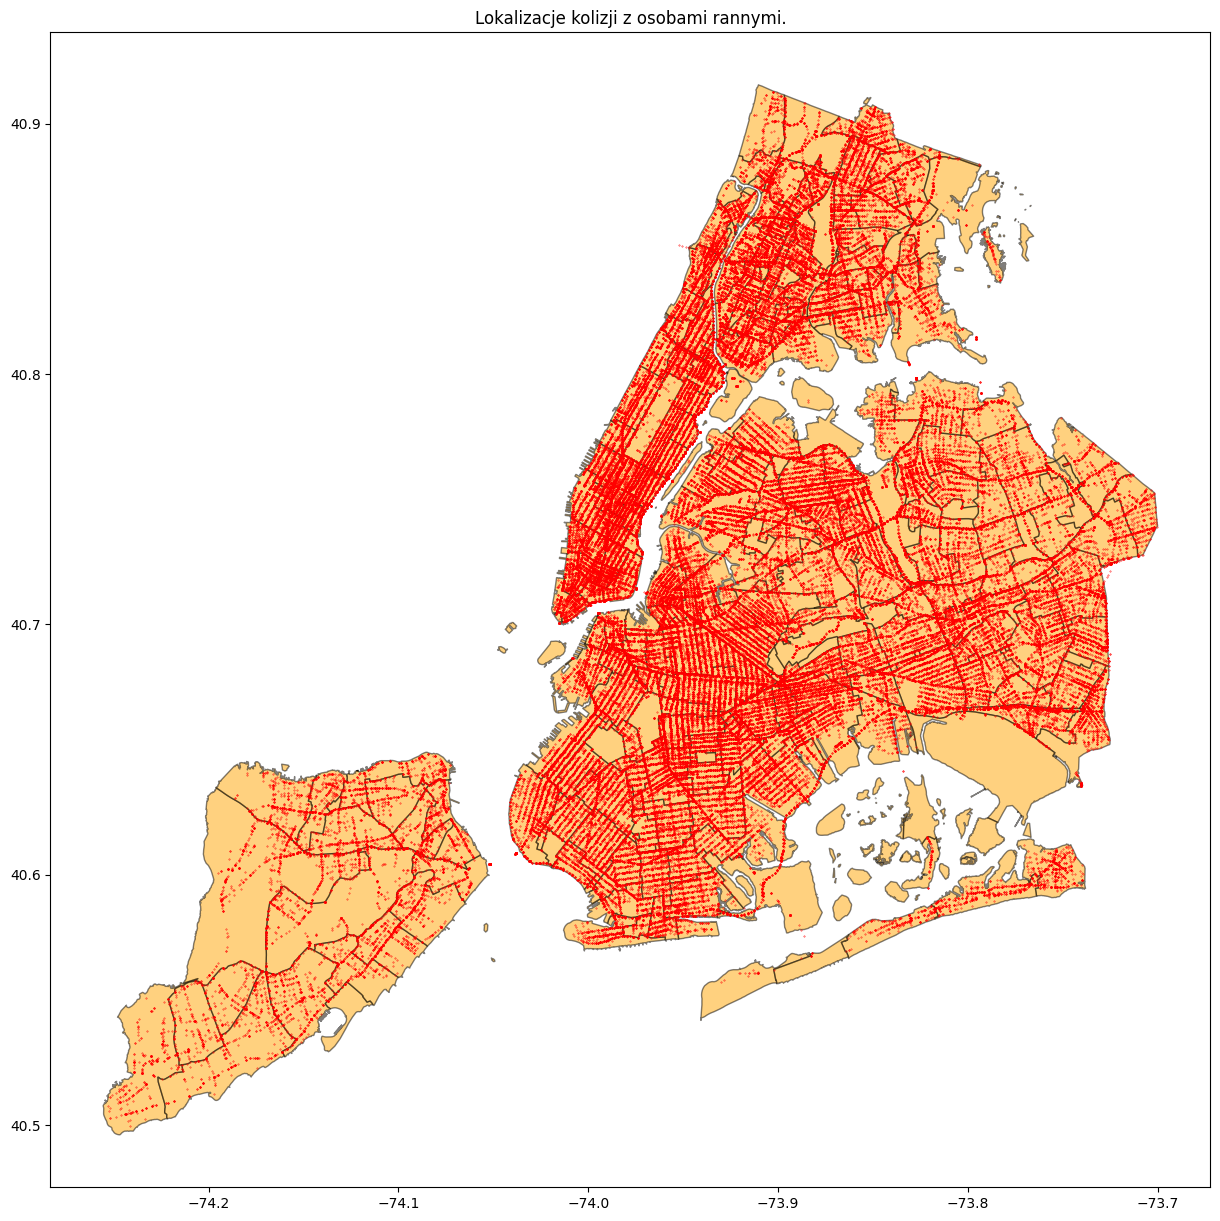

In [65]:
# Lokalizacje geograficzne kolizji w których były osoby ranne
persons_injured = gis_nyc_collisions.loc[gis_nyc_collisions["LocationNYC"]].merge(nyc_collisions[["NUMBER OF PERSONS INJURED","COLLISION_ID"]].loc[nyc_collisions["NUMBER OF PERSONS INJURED"] > 0],on="COLLISION_ID")
fig,ax = plt.subplots(1,1, figsize=(15,15))
base = neighborhood.plot(color="orange",alpha=0.5,edgecolor='black',ax=ax)
persons_injured.plot(ax=base, color="red", markersize=0.1)
ax.set_title("Lokalizacje kolizji z osobami rannymi.");

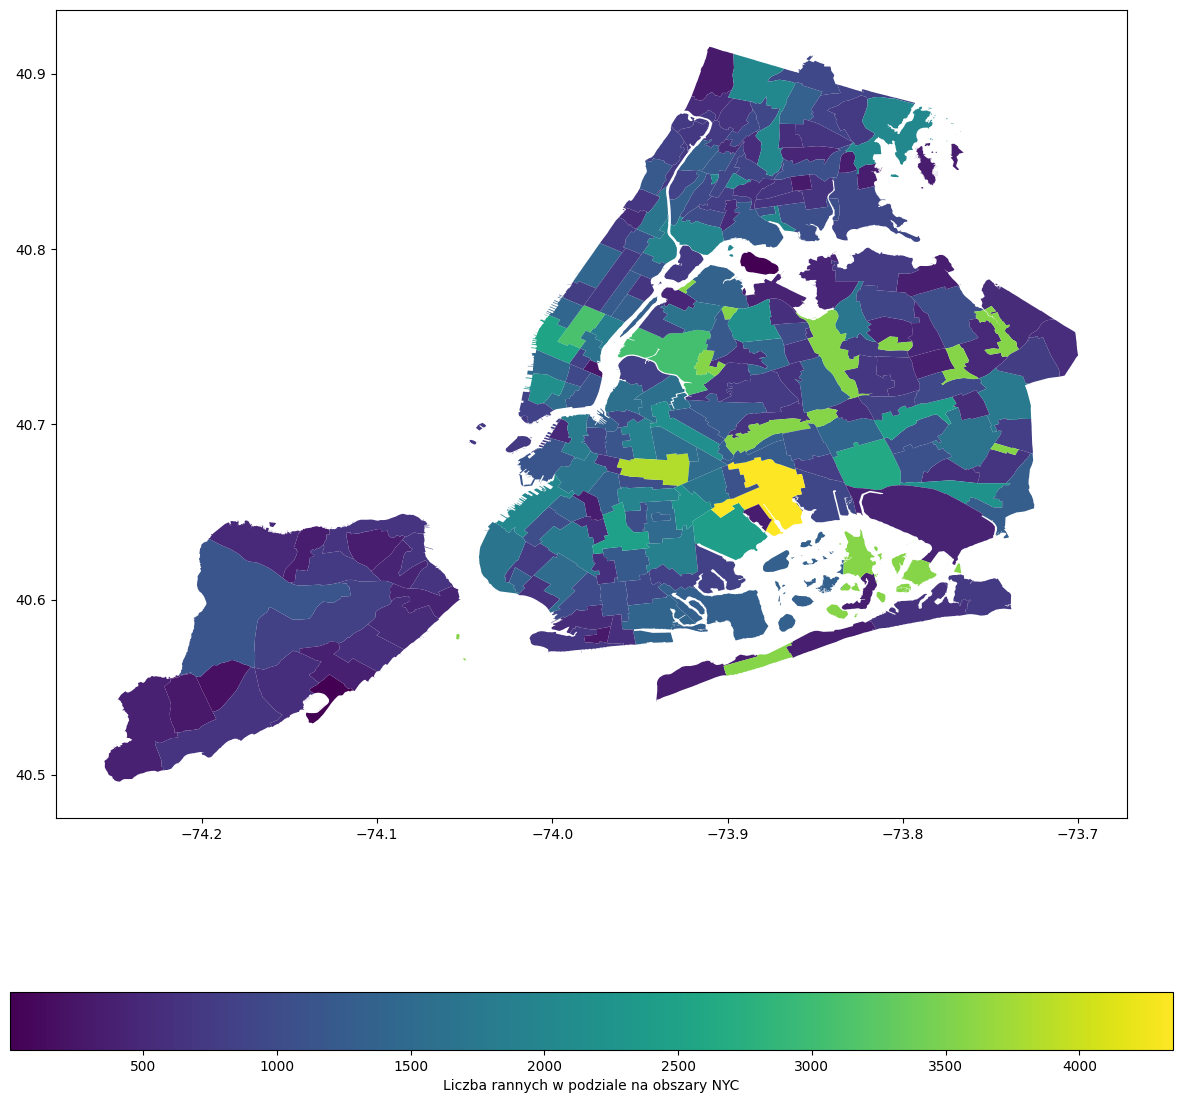

In [66]:
# Liczba rannych w podziale na obszary NYC
nta_injured = persons_injured.loc[~persons_injured["NTACode"].isna()].groupby("NTACode")["COLLISION_ID"].count().sort_values(ascending=False)
nta_injured.name = "Count"
fig,ax = plt.subplots(1,1, figsize=(15,15))
neighborhood.merge(nta_injured,on="NTACode").plot(column="Count", legend=True, legend_kwds={"label": "Liczba rannych w podziale na obszary NYC", "orientation": "horizontal"}, ax=ax);

In [67]:
# 10 obszarów NYC w których liczba rannych w kolizjach była największa
neighborhood[["NTACode","BoroCode","BoroName","neighbourhood"]].merge(nta_injured,on="NTACode").sort_values("Count", ascending=False).head(10)

NTACode  BoroCode   BoroName                               neighbourhood  \
136    BK82         3   BROOKLYN                               East New York   
68     BK61         3   BROOKLYN                         Crown Heights North   
171    QN99         4     QUEENS                    park-cemetery-etc-Queens   
80     MN17         1  MANHATTAN                       Midtown-Midtown South   
117    QN31         4     QUEENS        Hunters Point-Sunnyside-West Maspeth   
1      QN55         4     QUEENS                            South Ozone Park   
104    MN13         1  MANHATTAN  Hudson Yards-Chelsea-Flatiron-Union Square   
98     BK42         3   BROOKLYN                                    Flatbush   
2      BK50         3   BROOKLYN                                    Canarsie   
52     QN61         4     QUEENS                                     Jamaica   

     Count  
136   4348  
68    3839  
171   3557  
80    3093  
117   3046  
1     2626  
104   2542  
98    2451  
2     2425  
52    2400

**Dziesięć sąsiedztw i okręgów w których liczba rannych w kolizjach była największa.**

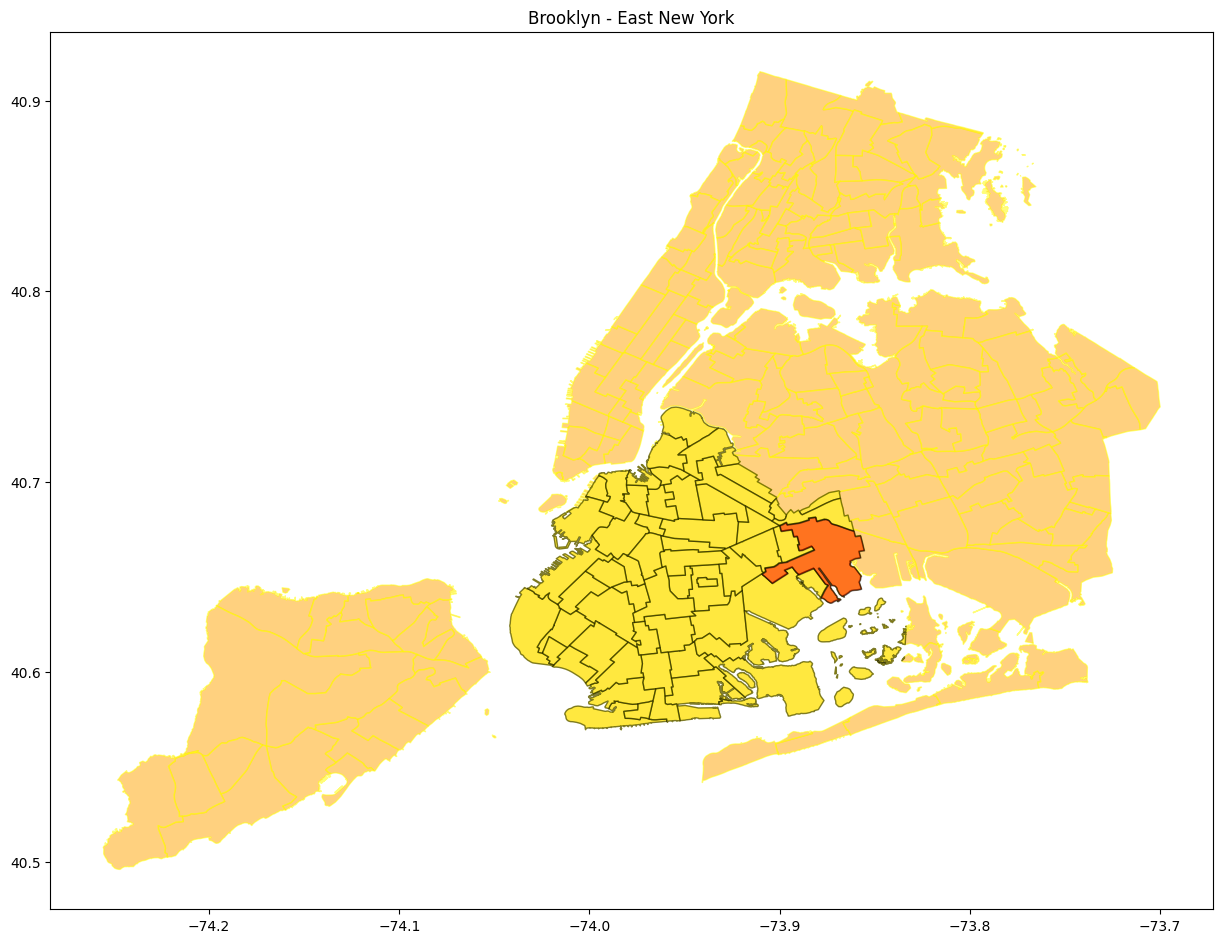

In [68]:
# Gdzie na mapie miasta Nowy Jork znajduje się East New York w dzielnicy Brooklyn z największą liczbą rannych
fig, ax = plt.subplots(1,1,figsize=(15,15))
ax.set_title("Brooklyn - East New York")
nyc = neighborhood.plot(color="orange",alpha=0.5,edgecolor='yellow',label="New York",ax=ax)
brooklyn = neighborhood.loc[neighborhood["BoroCode"] == 3].plot(color="yellow",alpha=0.5,edgecolor='black',label="Brooklyn",ax=nyc)
bk82 = neighborhood.loc[neighborhood["NTACode"] == "BK82"].plot(color="red",alpha=0.5,edgecolor='black',label="East New York",ax=brooklyn);

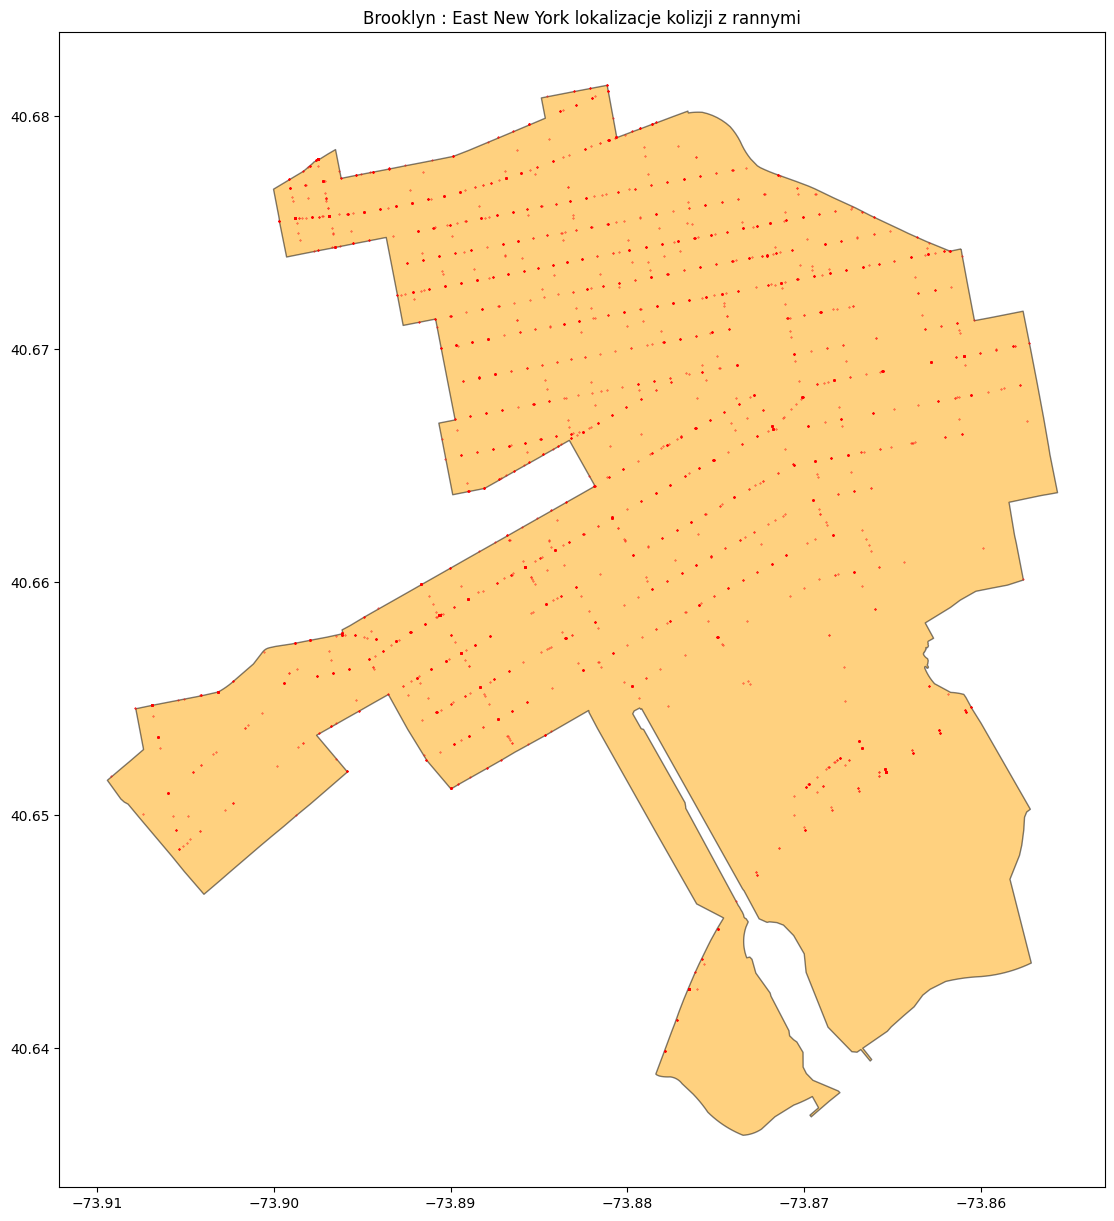

In [69]:
# Lokalizacja kolizji z rannymi w obszarze East New York
fig,ax = plt.subplots(1,1, figsize=(15,15))
ax.set_title("Brooklyn : East New York lokalizacje kolizji z rannymi")
bk82 = neighborhood.loc[neighborhood["NTACode"]=='BK82'].plot(color="orange",alpha=0.5,edgecolor='black',ax=ax)
persons_injured.loc[persons_injured["NTACode"]=='BK82'].plot(ax=bk82, color="red", markersize=0.1);

In [70]:
del(nta_injured)
del(persons_injured)
del(bk82)
del(brooklyn)
del(nyc)

#### Liczba rannych w kolizjach w podziale na okręgi NYC.

In [71]:
# Liczba rannych w kolizjach w podziale na okręgi NYC.
boro_injured = nyc_collisions.loc[(nyc_collisions["BoroCode"] > 0) & (nyc_collisions["NUMBER OF PERSONS INJURED"] > 0)].groupby("BoroCode")["COLLISION_ID"].count().sort_values(ascending=False)
boro_injured.name = "Count"
boro_injured.to_frame().merge(boroughs[["BoroName","BoroCode"]],on="BoroCode")[["BoroName","Count"]]
# BoroName
# Bronx            2
# Brooklyn         3
# Manhattan        1
# Queens           4
# Staten Island    5

BoroName  Count
0       BROOKLYN  68813
1         QUEENS  60355
2      MANHATTAN  36470
3          BRONX  32048
4  STATEN ISLAND   9696

**Liczba rannych w podziale na okręgi NYC**

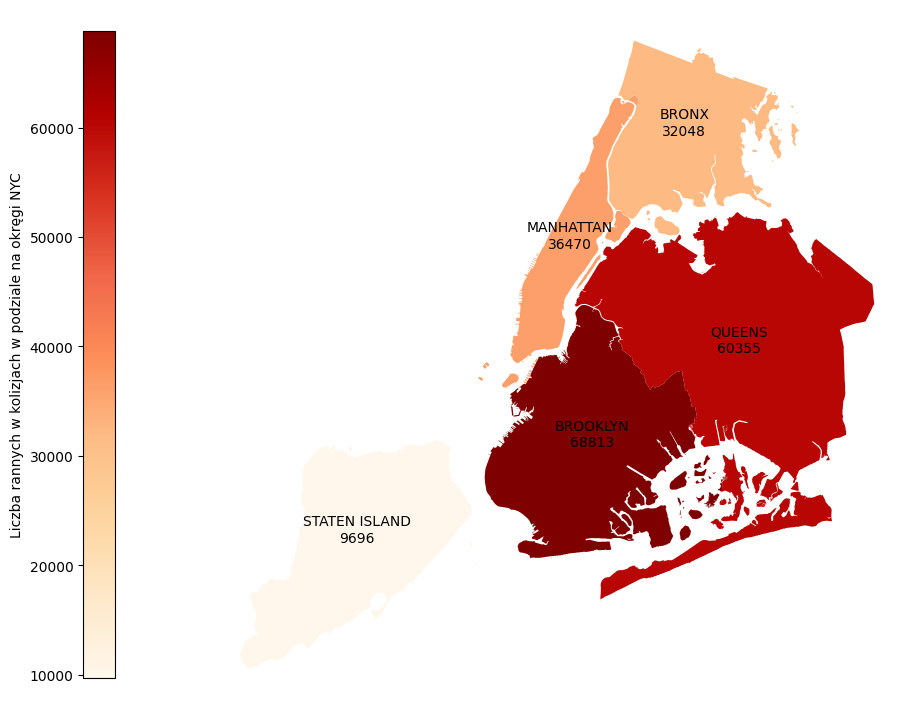

In [72]:
fig, ax = plt.subplots(1,1,figsize=(12,12))
boroughs.merge(boro_injured,on="BoroCode").plot(column="Count", legend=True, cmap="OrRd", legend_kwds={"label": "Liczba rannych w kolizjach w podziale na okręgi NYC", "orientation": "vertical", "location": "left", "shrink": 0.7}, ax=ax)
boroughs.merge(boro_injured,on="BoroCode").apply(lambda x: ax.annotate(text=x.BoroName+"\n"+str(x.Count), color='black', xy=x.geometry.centroid.coords[0],ha='center'), axis=1)
plt.axis("off");

#### Liczba zabitych w kolizjach w podziale na obszary i okręgi NYC.

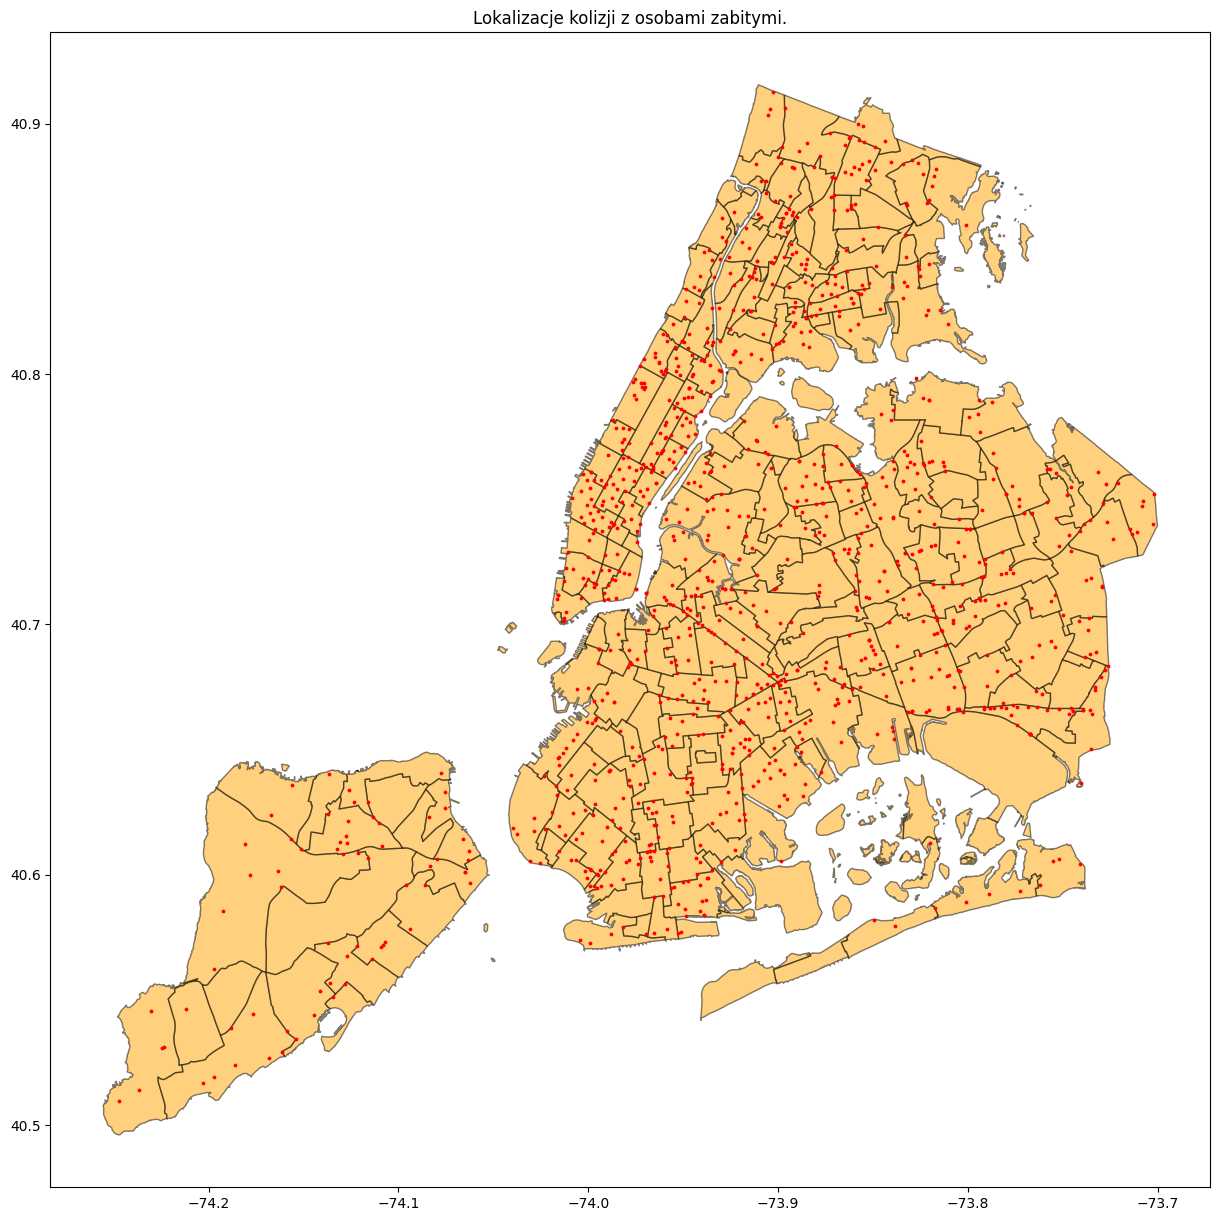

In [73]:
# Osoby zabite w podziale na obszary NYC
persons_killed = gis_nyc_collisions.loc[gis_nyc_collisions["LocationNYC"]].merge(nyc_collisions[["NUMBER OF PERSONS KILLED","COLLISION_ID"]].loc[nyc_collisions["NUMBER OF PERSONS KILLED"] > 0],on="COLLISION_ID")
fig,ax = plt.subplots(1,1, figsize=(15,15))
base = neighborhood.plot(color="orange",alpha=0.5,edgecolor='black',ax=ax)
persons_killed.plot(ax=base, color="red", markersize=3)
ax.set_title("Lokalizacje kolizji z osobami zabitymi.");

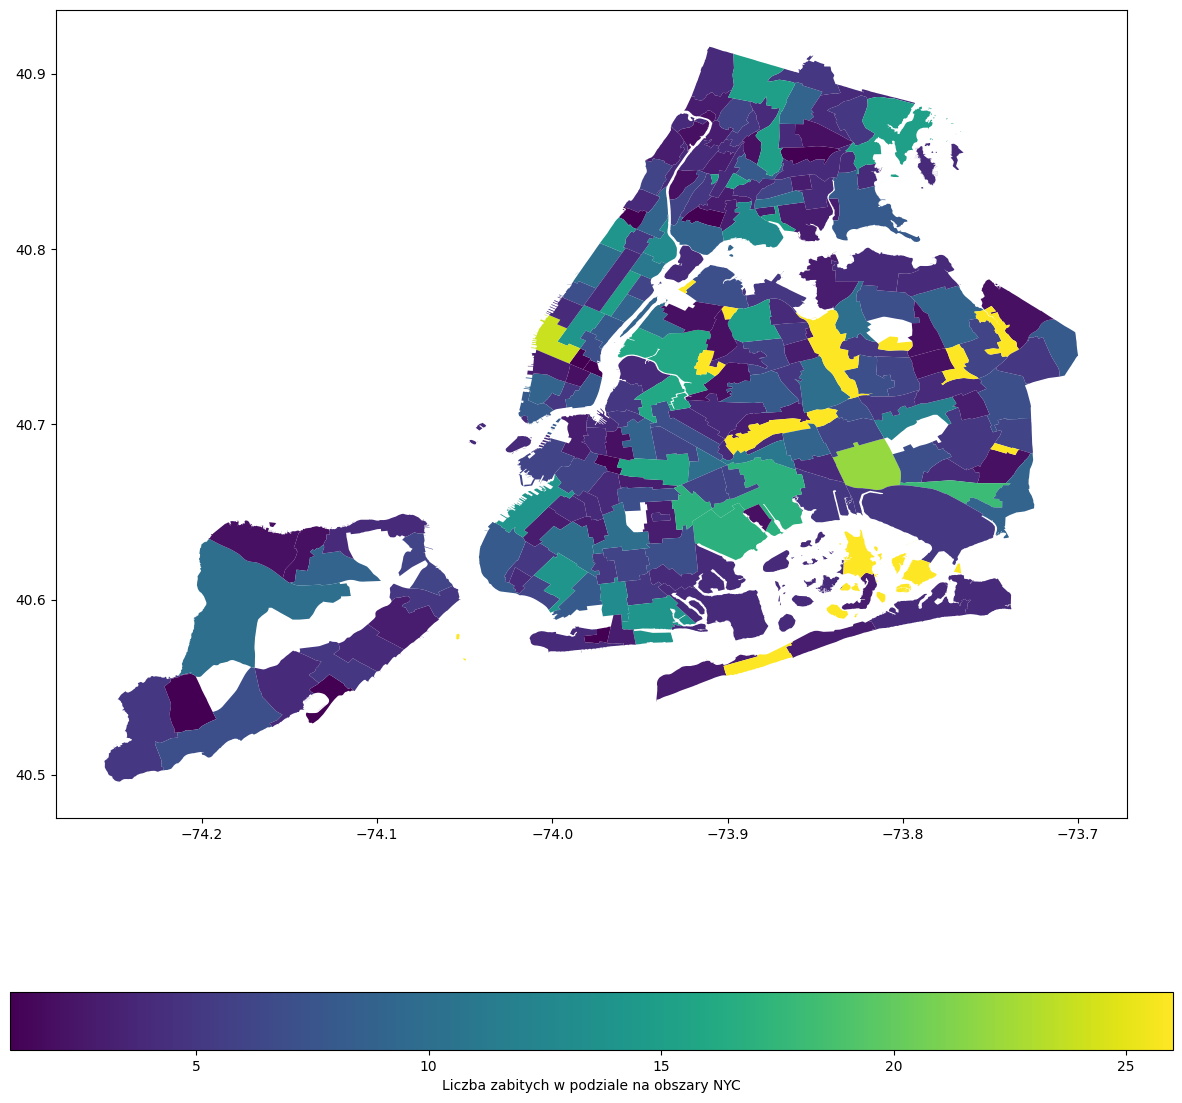

In [74]:
# Liczba zabitych w podziale na obszary NYC
nta_killed = persons_killed.loc[~persons_killed["NTACode"].isna()].groupby("NTACode")["COLLISION_ID"].count().sort_values(ascending=False)
nta_killed.name = "Count"
fig,ax = plt.subplots(1,1, figsize=(15,15))
neighborhood.merge(nta_killed,on="NTACode").plot(column="Count", legend=True, legend_kwds={"label": "Liczba zabitych w podziale na obszary NYC", "orientation": "horizontal"}, ax=ax);

In [75]:
# 10 obszarów NYC w których liczba zabitych w kolizjach była największa
neighborhood[["NTACode","BoroCode","BoroName","neighbourhood"]].merge(nta_killed,on="NTACode").sort_values("Count", ascending=False).head(10)

NTACode  BoroCode   BoroName                               neighbourhood  \
160    QN99         4     QUEENS                    park-cemetery-etc-Queens   
96     MN13         1  MANHATTAN  Hudson Yards-Chelsea-Flatiron-Union Square   
1      QN55         4     QUEENS                            South Ozone Park   
79     QN03         4     QUEENS        Springfield Gardens South-Brookville   
2      BK50         3   BROOKLYN                                    Canarsie   
154    BK96         3   BROOKLYN                        Rugby-Remsen Village   
126    BK82         3   BROOKLYN                               East New York   
108    QN31         4     QUEENS        Hunters Point-Sunnyside-West Maspeth   
148    BK90         3   BROOKLYN                           East Williamsburg   
62     BK61         3   BROOKLYN                         Crown Heights North   

     Count  
160     26  
96      24  
1       22  
79      18  
2       17  
154     17  
126     17  
108     16  
148     16  
62      16

**Dziesięć sąsiedztw i obszarów w których liczba zabitych w kolizjach była największa.**

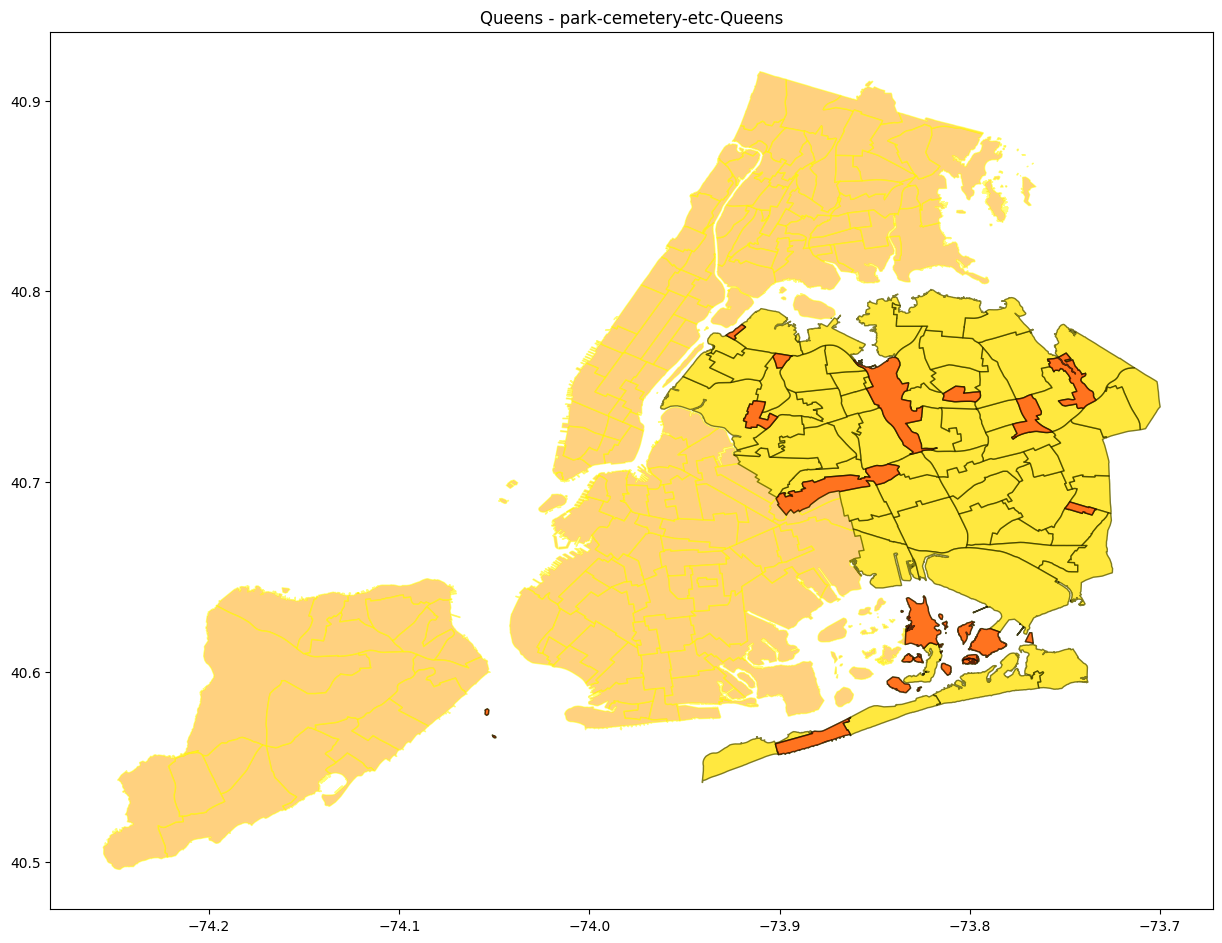

In [76]:
# Gdzie na mapie miasta Nowy Jork znajduje się park-cemetery-etc-Queens w dzielnicy Queens z największą liczbą zabitych
fig, ax = plt.subplots(1,1,figsize=(15,15))
ax.set_title("Queens - park-cemetery-etc-Queens")
nyc = neighborhood.plot(color="orange",alpha=0.5,edgecolor='yellow',label="New York",ax=ax)
queens = neighborhood.loc[neighborhood["BoroCode"] == 4].plot(color="yellow",alpha=0.5,edgecolor='black',label="Queens",ax=nyc)
qn99 = neighborhood.loc[neighborhood["NTACode"] == "QN99"].plot(color="red",alpha=0.5,edgecolor='black',label="park-cemetery-etc-Queens",ax=queens);

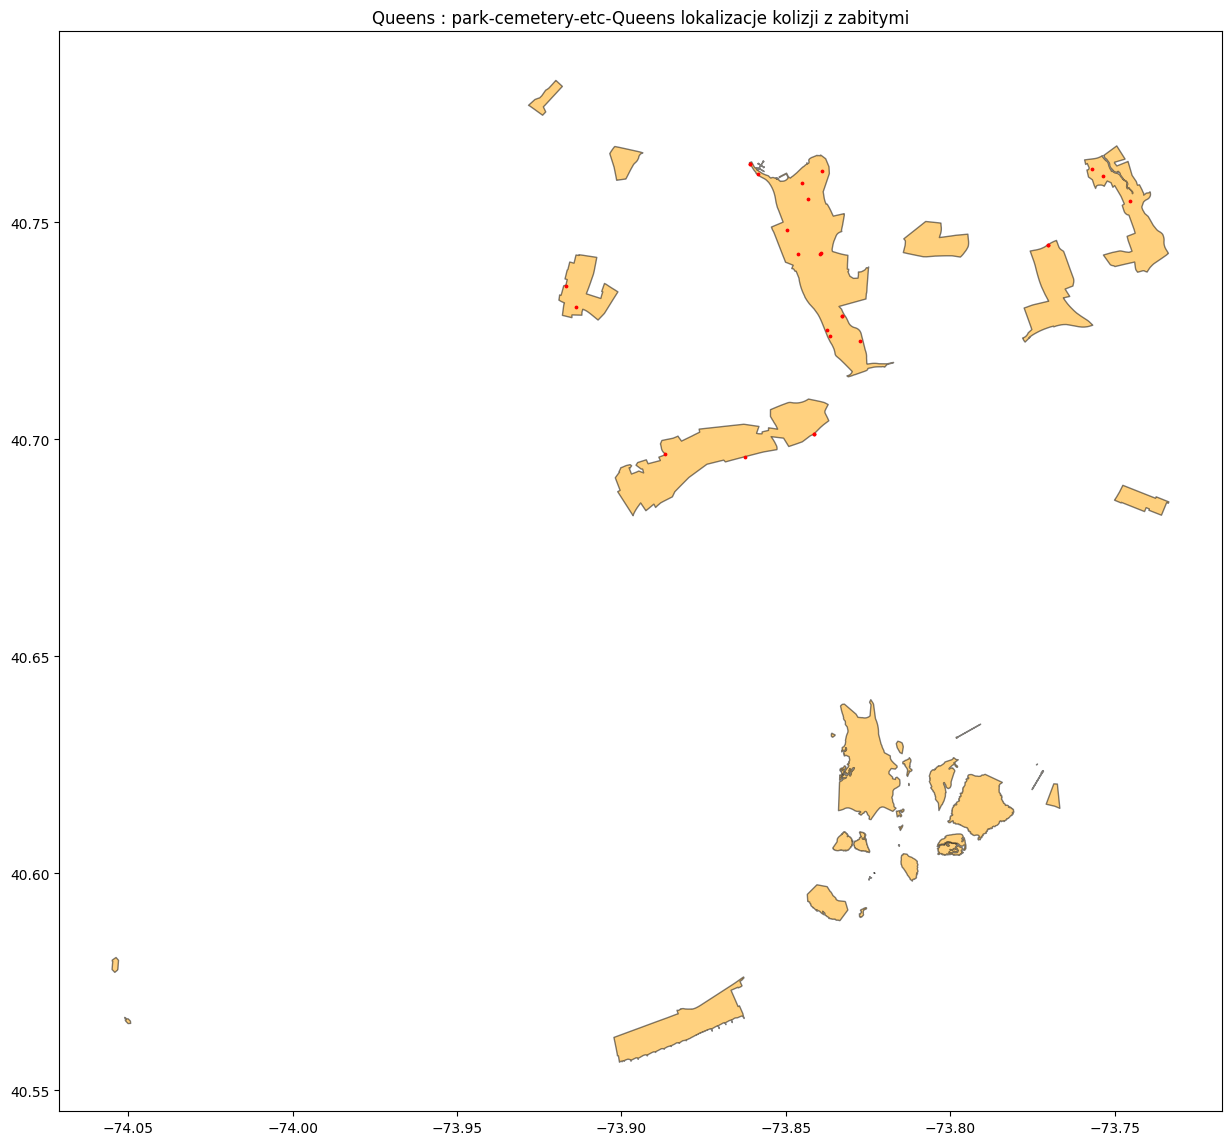

In [77]:
# Lokalizacja kolizji z zabitymi w obszarze park-cemetery-etc-Queens
fig,ax = plt.subplots(1,1, figsize=(15,15))
ax.set_title("Queens : park-cemetery-etc-Queens lokalizacje kolizji z zabitymi")
qn99 = neighborhood.loc[neighborhood["NTACode"]=='QN99'].plot(color="orange",alpha=0.5,edgecolor='black',ax=ax)
persons_killed.loc[persons_killed["NTACode"]=='QN99'].plot(ax=qn99, color="red", markersize=3);

In [78]:
del(nta_killed)
del(nyc)
del(queens)
del(qn99)

In [79]:
# Liczba zabitych w kolizjach w podziale na okręgi NYC.
boro_killed = nyc_collisions.loc[(nyc_collisions["BoroCode"] > 0) & (nyc_collisions["NUMBER OF PERSONS KILLED"] > 0)].groupby("BoroCode")["COLLISION_ID"].count().sort_values(ascending=False)
boro_killed.name = "Count"
boro_killed.to_frame().merge(boroughs[["BoroName","BoroCode"]],on="BoroCode")[["BoroName","Count"]]

BoroName  Count
0         QUEENS    363
1       BROOKLYN    344
2      MANHATTAN    214
3          BRONX    183
4  STATEN ISLAND     68

**Liczba zabitych w podziale na okręgi NYC**

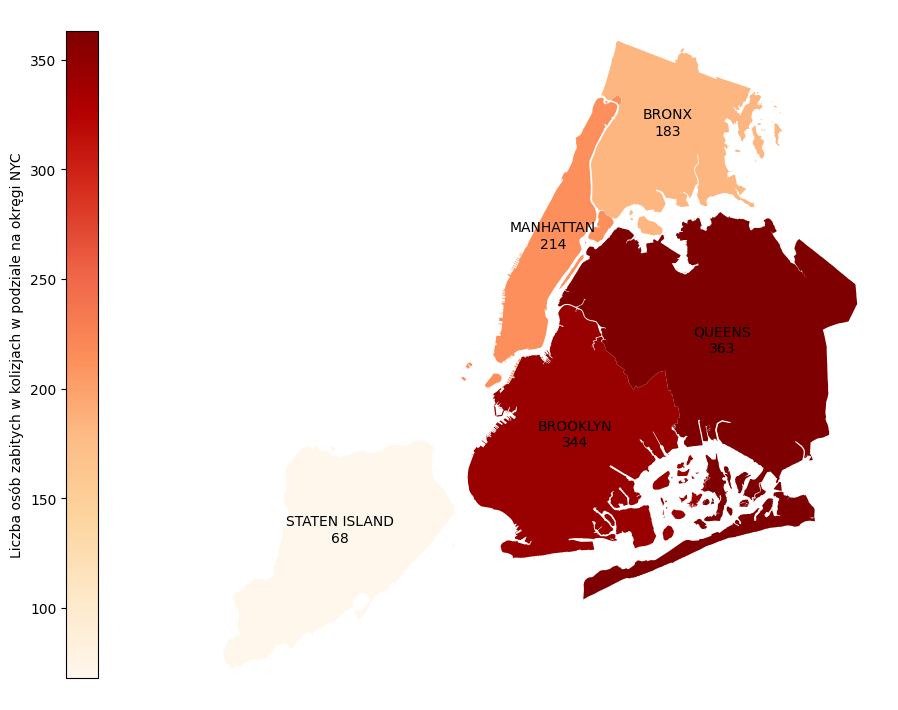

In [80]:
fig, ax = plt.subplots(1,1,figsize=(12,12))
boroughs.merge(boro_killed,on="BoroCode").plot(column="Count", legend=True, cmap="OrRd", legend_kwds={"label": "Liczba osób zabitych w kolizjach w podziale na okręgi NYC", "orientation": "vertical", "location": "left", "shrink": 0.7}, ax=ax)
boroughs.merge(boro_killed,on="BoroCode").apply(lambda x: ax.annotate(text=x.BoroName+"\n"+str(x.Count), color='black', xy=x.geometry.centroid.coords[0],ha='center'), axis=1)
plt.axis("off");

Największa liczba zabitych w kolizach to okręg Queens

In [81]:
del(persons_killed)
del(boro_killed)

### Wnioski:

Dane zawarte w pliku csv nypd-motor-vehicle-collisions.csv są bardzo problematyczne.
- Przede wszystkim brak metadanych opisujących zawartość każdej z kolumn.
- Prawie 11% danych zawartych w nypd-motor-vehicle-collisions.csv nie posiada prawidłowego przypisania do jakiej kolwiek lokalizacji. W związku z powyższym trudno określić jak te dane były by rozłożone po okręgach NYC.
- Brak ujednoliconych słowników opisujących przyczyny kolizji i typy pojazdów uczestniczących w kolizjach, co wiąże sie z dużym nakładem pracy w czyszczeniu danych. Niestety w wielu przypadkach poprawa tkich danych jest prawie niemożliwa (np. w przypadku typów pojazdów uczestniczących w kolizach). Wiele nazw może opisywać ten sam typ pojazdu lub czynnik kolizji. Analizy oparte na nie ustrukturyzowanych danych obarczone są błędami.
- Powielone identyfikatory kolizji.

Analiza danych zawartych w nypd-motor-vehicle-collisions.csv wykazała że:
- Dwoma zbilożonym do siebie okręgami pod względem liczby kolizji są Brooklyn i Queens, najmniejszą liczbą kolizji zanotowano w okręgu Staten Island.
- Najczęstrzymi przyczynami kolizji są DRIVER INATTENTION/DISTRACTION (nieuwaga/rozproszenie kierowcy), FAILURE TO YIELD RIGHT-OF-WAY (nieudzielenie pierszeństwa przejazdu), FOLLOWING TOO CLOSELY (zbyt bliska jazda za innym pojazdem)
- Okręgiem przodującym zarówno w liczbie osób zabitych jak i rannych w wyniku zbyt szybkiej jazdy jest okręg Queens drugie miejsce zajmuje Brooklyn.
- Całościowo bez względu na czynnik wypadku/kolizji w liczbie rannych przoduje okręg Brooklyn, natomiast w liczbie zabitych okręg Queens. Ogólnie liczba zabitych w wypadkach ma tendencję spadkową, natomiast rannych wzrastającą.
- Najczęstrzym typem pojazdu uczystniczącym w kolizjach/wypadkach jest samochód osobowy.
Niestety brak słownika z typami smaochodów uniemożliwia rzetelną analizę, przykładem jest typ pojazdu SPORT UTILITY / STATION WAGON i STATION WAGON/SPORT UTILITY VEHICLE który prawdopodobnie dotyczy tego samego typu pojazdu (problematyczne dane).